# Лабораторная №3. Unsupervised

В этом лабораторной работе мы будем обрабатывать наш датасет, исследовать его, а также обучать модели без учителя на примере `KNears`, а также делать `Custom KNears`

- В конфигурации настраиваются:
  - путь к файлу
  - переименование столбцов для удобства понимания после one-hot encoding
  - Выбор данных (покупка в собственность/аренда)
  - Настройка квантилей для устранения выбросов

## Импорты

In [14]:
import warnings

# Отключаем все предупреждения
warnings.filterwarnings('ignore')

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Union, List

In [16]:
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from hdbscan import HDBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

## Конфигурация

In [17]:
# config
file_path = "../../parser-GameTrue/Lab_1/resultCSV/Summarize.xlsx"
debug_file_path = "./newData.csv"
data_rename = {'Интернет и ТВ':'Сеть', 'Балкон или лоджия':'Балкон', 'Region':'Город'}
buy_or_rent = 'Купить'				# 'Купить' / 'Снять'
quantile_1 = 0.2
quantile_2 = 0.8
DEBUG = False
custom_value_debug = False
custom_data_debug = 'Excel' 		# 'Excel' / 'Manual'
scoring_error = 'neg_mean_absolute_error'
scoring_type = "MAE"


## Функции

In [18]:
def check_data(data : pd.DataFrame, debug : bool=DEBUG, debugPercent : int=45) -> None: 
    """
    Проверяет наличие пропусков в данных и выводит статистику.

    Параметры:
    - data (pd.DataFrame): Исходный DataFrame.
    - debug (bool): Если True, выводит дополнительную информацию о пропусках в каждом столбце.

    Возвращает:
    - None.
    """
    
    total_rows = data.shape[0]
    rows_with_all_data = data.dropna().shape[0]

    print(f"Количество строк с полными данными: {rows_with_all_data}")
    print(f"Количество строк с пропусками: {total_rows - rows_with_all_data}")

    if debug:
        print("\nКоличество пропусков в каждом столбце:")
        missing_values = data.isnull().sum()
        print(missing_values[missing_values > 0])

        print(f"\nПроцент пропущенных значений (>{debugPercent}%) в каждом столбце:")
        missing_percentage = data.isnull().mean() * 100
        print(missing_percentage[missing_percentage > debugPercent])


In [19]:
def print_missing(data : pd.DataFrame, column : str) -> None:
	"""
    Выводит строки с пропущенными значениями в указанном столбце.

    Параметры:
    - data (pd.DataFrame): Исходный DataFrame.
    - column (str): Название столбца для проверки на пропуски.

    Возвращает:
    - None.
    """
    
	print(f"Строки с пропусками в столбце '{column}':")
	print(data[data[column].isna()])

In [20]:
def pd_to_int(data : pd.DataFrame, target_columns : Union[str, List[str]], debug : bool=DEBUG) -> pd.DataFrame:
    """
    Преобразует указанные столбцы DataFrame в целочисленный тип, заменяя пропуски на 0.
    
    Аргументы:
		- **data**: pd.DataFrame — исходный DataFrame.
		- **target_columns**: Union[str, List[str]] — столбец или список столбцов для преобразования.
		- **debug**: bool — если True, выводит уникальные значения и тип данных каждого обработанного столбца.
    
    Возвращает:
    	- pd.DataFrame с преобразованными столбцами.
    """
	
	# Если target_columns строка, превращаем её в список из одного элемента
    if isinstance(target_columns, str):
        target_columns = [target_columns]

    # Проходим по каждому столбцу в списке target_columns
    for column in target_columns:
        # Преобразуем значения столбца к числовому типу
        data[column] = pd.to_numeric(data[column], errors='coerce')
        # Заполняем NaN значением 0 и преобразуем к целочисленному типу
        data[column] = data[column].fillna(0).astype(int)
        # Проверяем уникальные значения в текущем столбце
        if debug:
            unique_vals = data[column].unique()
            print(f"Unique values in column '{column}': {unique_vals[:10]}{'...' if len(unique_vals) > 10 else ''}")
            print(f"Data type of column '{column}': {data[column].dtype}")

    return data

In [21]:
def pd_type(data : pd.DataFrame, target_columns : Union[str, List[str]]) -> None:
	"""
    Выводит типы данных указанных столбцов.

    Параметры:
		- **data** (pd.DataFrame): Исходный DataFrame.
        - **target_columns** (Union[str, List[str]]): Столбец или список столбцов для проверки типа данных.

    Возвращает:
    	- None.
    """
	
	if isinstance(target_columns, str):
		target_columns = [target_columns]

    # Проходим по каждому столбцу в списке target_columns
	for column in target_columns:
		print(f"Data type of column '{column}': {data[column].dtype} \n")

In [22]:
def fill_missing_area_by_ratio(data : pd.DataFrame, target_column : str, base_column : str, group_column : str, studio_ratio=None, debug=DEBUG):
    """
    Заполняет пропуски в площади (target_column) на основе отношения к общей площади (base_column), сгруппированных по количеству комнат (group_column).
    
    Параметры:
		- **data** (pd.DataFrame): Исходный DataFrame.
		- **target_column** (str): Столбец для заполнения пропусков (например, "Площадь кухни").
		- **base_column** (str): Столбец для расчета коэффициента (например, "Общая площадь").
		- **group_column** (str): Столбец для группировки (например, "Количество комнат").
		- **studio_ratio** (float, optional): Фиксированный коэффициент для студий.
		- **debug** (bool): Если True, выводит средние коэффициенты по группам.

    Возвращает:
    	- **pd.DataFrame**: DataFrame с заполненными значениями в target_column.
    """
    # Рассчитаем коэффициент площади (target_column / base_column) по каждой группе
    data['Коэффициент'] = data[target_column] / data[base_column]
    
    # Рассчитываем средний коэффициент для каждой группы по количеству комнат, исключая строки с NaN
    mean_ratio_by_rooms = (
		data.groupby(group_column)
		.apply(lambda x: (x[target_column] / x[base_column]).mean())
	)
    
    if debug:
         print(mean_ratio_by_rooms)
    
    # Функция для заполнения пропусков
    def fill_area(row):
        if pd.isna(row[target_column]):
            room_count = row[group_column]
            if room_count == 0 and studio_ratio:  # Если студия (0 комнат) и указан коэффициент
                return studio_ratio * row[base_column]
            elif room_count in mean_ratio_by_rooms.index:  # Если есть коэффициент для данного количества комнат
                return mean_ratio_by_rooms[room_count] * row[base_column]
        return row[target_column]
    
    # Применяем функцию к строкам с пропусками
    data[target_column] = data.apply(fill_area, axis=1)
    
    # Округляем результат до одного знака после запятой
    data[target_column] = data[target_column].round(1)
    
    # Удаляем временный столбец с коэффициентом
    data.drop(columns=['Коэффициент'], inplace=True)
    
    return data

In [23]:
def fix_year(year : Union[float, int]) -> int:
    """
    Приводит год к формату полной даты, добавляя 1900 или 2000.

    Параметры:
    	- **year** (Union[float, int]): Год для корректировки.

    Возвращает:
    	- **int**: Исправленный год.
    
    Например:
		- 99 -> 1999
		- 87 -> 1987
		- 04 -> 2004
    """


    if year > 24 and year < 1000:
        return year + 1900
    elif year <= 24:
        return year + 2000
    else:
        return year

In [24]:
def one_hot_encode_multilabel(data : pd.DataFrame, target_columns : Union[str, List[str]], prefix:bool=False) -> pd.DataFrame:
    """
    Применяет One-Hot Encoding к мульти-меточным столбцам.

    Параметры:
    - data (pd.DataFrame): Исходный DataFrame.
    - target_columns (Union[str, List[str]]): Столбец или список столбцов для кодирования.
    - prefix (bool): Если True, добавляет префикс названия столбца к новым столбцам.

    Возвращает:
    - pd.DataFrame: Обновленный DataFrame с закодированными значениями.
    """
    
    if isinstance(target_columns, str):
        target_columns = [target_columns]

    for column in target_columns:
        dummies = data[column].str.get_dummies(sep=', ')
        if prefix:
            dummies = dummies.add_prefix(f"{column}: ")
        data = pd.concat([data, dummies], axis=1).drop(columns=[column])

    return data

In [25]:
def extract_category_column(data: pd.DataFrame, prefixes: Union[str, List[str]]) -> pd.DataFrame:
    """
    Anti One-Hot Encoding function
    
    Извлекает значения с 1 из столбцов, соответствующих указанным префиксам, 
    и объединяет их в строку через запятую для каждого префикса.

    Параметры:
    - data: pd.DataFrame — исходный DataFrame.
    - prefixes: list — список префиксов столбцов для извлечения значений.

    Возвращает:
    - pd.DataFrame с объединенными значениями для каждого префикса.
    """
    
    # Если передан один префикс в виде строки, преобразуем его в список для унификации обработки
    if isinstance(prefixes, str):
        prefixes = [prefixes]

    result_df = pd.DataFrame()

    for prefix in prefixes:
        # Фильтруем только столбцы, начинающиеся на текущий префикс
        category_columns = [col for col in data.columns if col.startswith(prefix)]

        if not category_columns:
            raise ValueError(f"В DataFrame нет столбцов, начинающихся с '{prefix}'")

        # Объединяем значения для каждой строки
        combined_column = data[category_columns].apply(lambda row: ', '.join(
            col.split(": ")[-1] for col, val in row.items() if val == 1
        ), axis=1)

        # Добавляем новый столбец в итоговый DataFrame
        new_column_name = prefix.rstrip(":")  # Удаляем двоеточие в конце, если есть
        result_df[new_column_name] = combined_column

    return result_df


## Обработка данных

### Подключение файла

In [26]:

# Load the dataset
data = pd.read_excel(file_path, sheet_name="Summarize")

# Show the first few rows of 	the dataset to understand its structure
data.head()


,Вид сделки,Общая площадь,URL,Грузовой лифт,Ремонт,Дополнительно,Тёплый пол,В доме,Техника,Тип дома,...,Тип комнат,Комфорт,Этажей в доме,Площадь кухни,Количество комнат,Парковка,Способ продажи,Жилая площадь,Запланирован снос,Отделка
0,NaN,54.9,https://www.avito.ru/sankt-peterburg/kvartiry/...,1.0,дизайнерский,NaN,NaN,NaN,"кондиционер, холодильник, плита, микроволновка...",панельный,...,изолированные,NaN,12.0,9.6,2.0,NaN,NaN,31.0,NaN,NaN
1,возможна ипотека,55.6,https://www.avito.ru/sankt-peterburg/kvartiry/...,1.0,требует ремонта,NaN,NaN,NaN,NaN,монолитно-кирпичный,...,изолированные,NaN,13.0,17.4,2.0,подземная,свободная,27.3,NaN,NaN
2,возможна ипотека,47.5,https://www.avito.ru/sankt-peterburg/kvartiry/...,1.0,дизайнерский,"гардеробная, панорамные окна",есть,консьерж,"холодильник, стиральная машина, посудомоечная ...",монолитный,...,NaN,NaN,7.0,28.0,1.0,подземная,свободная,NaN,NaN,NaN
3,возможна ипотека,21.8,https://www.avito.ru/sankt-peterburg/kvartiry/...,1.0,дизайнерский,NaN,NaN,NaN,"холодильник, стиральная машина",монолитно-кирпичный,...,NaN,NaN,22.0,NaN,студия,"наземная многоуровневая, открытая во дворе",свободная,NaN,NaN,NaN
4,возможна ипотека,32.4,https://www.avito.ru/sankt-peterburg/kvartiry/...,NaN,дизайнерский,NaN,NaN,"мусоропровод, газ","холодильник, стиральная машина",панельный,...,NaN,NaN,9.0,6.6,1.0,открытая во дворе,свободная,18.6,NaN,NaN


### Обработка данных

#### Drop
Дропаем ненужные(тяжело обрабатывамые/не имеющие возможность подставить подходящее для дальнейшего обучения/мало квартир содержат данные) колонки

In [27]:
check_data(data, True)

Количество строк с полными данными: 0
Количество строк с пропусками: 11063

Количество пропусков в каждом столбце:
Вид сделки                     9475
Грузовой лифт                  4718
Ремонт                         1189
Дополнительно                  9802
Тёплый пол                    10855
В доме                         9640
Техника                        2307
Тип дома                       1175
Двор                           9098
Мебель                         3151
Интернет и ТВ                  4894
Пассажирский лифт              3623
Залог                          9891
Окна                           8969
Год постройки                  4931
Кровати                        9949
Балкон или лоджия              4085
Высота потолков                9659
Возможна помесячная аренда    10145
Санузел                        2151
Тип комнат                     7188
Комфорт                        9927
Этажей в доме                    44
Площадь кухни                  3143
Парковка             

In [28]:
drop_list = ["Адрес", "PhotoLinks", "URL", "Кровати", 'Вид сделки', "Дополнительно", "В доме",
			  "Двор", "Окна", "Высота потолков", "Способ продажи", "Запланирован снос", "Отделка",
			    "Тип комнат", "Возможна помесячная аренда", "Комфорт"]

In [29]:
data = data.drop(columns=drop_list)


#### Обработка пропуков

##### Обработка значений по лифту

In [30]:
# Если пропуск в "Грузовой лифт" или "Грузовой лифт" == "нет", то 0 
data.loc[(data['Грузовой лифт'] == 'нет') | (data['Грузовой лифт'].isna()), 'Грузовой лифт'] = 0

# Если пропуск в "Пассажирский лифт" и "Этажей в доме" <= 5, то 0
data.loc[data['Пассажирский лифт'].isna() & (data['Этажей в доме'] <= 5), 'Пассажирский лифт'] = 0

# Если пропуск в "Пассажирский лифт" и "Этажей в доме" > 5, то 1
data.loc[data['Пассажирский лифт'].isna() & (data['Этажей в доме'] > 5), 'Пассажирский лифт'] = 1


##### Обработка простых пропусков

In [31]:
# Заменим значения "студия" на 0
data['Количество комнат'].replace('студия', 0, inplace=True)

# Заменим значения "студия" на 0
data['Парковка'].replace('нет', np.nan, inplace=True)

# Затем заполним пропущенные значения (NaN) нулями
data['Залог'].fillna(0, inplace=True)

# Сначала заменим значения "0" на среднее значение года
data['Год постройки'].replace(0, 1980, inplace=True)

# Затем заполним пропущенные значения (NaN) на среднее значение года
data['Год постройки'].fillna(1980, inplace=True)

# # Затем заполним пропущенные значения (NaN) Теплого пола
# data['Тёплый пол'].fillna("нет", inplace=True)

# # Затем заполним пропущенные значения (NaN) на парковку во дворе
# data['Парковка'].fillna("открытая во дворе", inplace=True)

# # Затем заполним пропущенные значения (NaN) на "нет"
# data['Балкон или лоджия'].fillna("Нет", inplace=True)

# # Затем заполним пропущенные значения (NaN) в ремонте
# data['Ремонт'].fillna("косметический", inplace=True)

# # Затем заполним пропущенные значения (NaN) Интернета и ТВ
# data['Интернет и ТВ'].fillna("Не указано", inplace=True)

# # Затем заполним пропущенные значения (NaN) Интернета и ТВ
# data['Техника'].fillna("Не указано", inplace=True)

# # Затем заполним пропущенные значения (NaN) для Санузла
# data['Санузел'].fillna("совмещенный", inplace=True)

In [32]:
# Применяем функцию ко всему столбцу с годами постройки
data['Год постройки'] = data['Год постройки'].apply(fix_year)

# # Проверяем результат
# print(data['Год постройки'].unique())

In [33]:
# Рассчитываем средний год постройки для каждого города
# mean_year_by_city = data_rent2.groupby('Region')['Год постройки'].transform('mean').unique()

# mean_year_by_city

##### Обрабатываем пропуски разделения площади (Жилая/Кухня)

In [34]:
# Проверим наличие пропусков в "Общая площадь"
print(data['Общая площадь'].isna().sum())



0


In [35]:
# Сначала сохраняем строки с пропусками в "Жилая площадь" до изменений
before_changes = data[data['Жилая площадь'].isna()].copy()

In [36]:
# Применение функции для "Площадь кухни" с коэффициентом для студий
data = fill_missing_area_by_ratio(data, target_column='Площадь кухни', base_column='Общая площадь', 
                                  group_column='Количество комнат', studio_ratio=0.3129496, debug=True)

# Применение функции для "Жилая площадь" (если коэффициент для студий не требуется, можно не указывать)
data = fill_missing_area_by_ratio(data, target_column='Жилая площадь', base_column='Общая площадь', 
                                  group_column='Количество комнат', debug=True)

Количество комнат
0           NaN
1.0    0.257698
2.0    0.181022
3.0    0.151457
4.0    0.120315
5.0    0.131549
6.0    0.098039
9.0    0.176471
dtype: float64
Количество комнат
0      0.758463
1.0    0.531991
2.0    0.629021
3.0    0.664857
4.0    0.695990
5.0    0.634700
6.0         NaN
9.0    0.784314
dtype: float64


In [37]:
# Сохраняем строки после изменений
after_changes = data.loc[before_changes.index]

# Сравниваем до и после
comparison = pd.concat([before_changes['Жилая площадь'], after_changes['Жилая площадь']], axis=1)
comparison.columns = ['Before', 'After']

# Выводим результат
print(comparison)

       Before  After
2         NaN   25.3
3         NaN   16.5
10        NaN   68.2
11        NaN   17.6
15        NaN   36.7
...       ...    ...
11050     NaN   22.9
11051     NaN   22.0
11056     NaN   44.0
11058     NaN   32.7
11060     NaN   29.6

[4379 rows x 2 columns]


In [38]:
# # Сначала сохраняем строки с пропусками в "Площадь кухни" до изменений
# before_changes = data[data['Площадь кухни'].isna()].copy()

# # Рассчитаем среднее соотношение "Площадь кухни / Общая площадь" для каждого количества комнат
# mean_ratio_by_rooms = (
#     data.groupby('Количество комнат')
#     .apply(lambda x: (x['Жилая площадь'] / x['Общая площадь']).mean())
# )



# mean_ratio_by_rooms

In [39]:
# print_missing(data, "Площадь кухни")

In [40]:
# # Определим фиксированный коэффициент для студий
# studio_ratio = 0.3129496

# # Функция для заполнения пропусков
# def fill_kitchen_area(row):
#     if pd.isna(row['Площадь кухни']):
#         room_count = row['Количество комнат']
#         if room_count == 0:  # Если студия (0 комнат)
#             return studio_ratio * row['Общая площадь']
#         elif room_count in mean_ratio_by_rooms.index:  # Если есть коэффициент для данного количества комнат
#             return mean_ratio_by_rooms[room_count] * row['Общая площадь']
#     return row['Площадь кухни']

# # Применяем функцию к строкам с пропусками
# data['Площадь кухни'] = data.apply(fill_kitchen_area, axis=1)

# # Округляем значения в столбце "Площадь кухни" до одного знака после запятой
# data['Площадь кухни'] = data['Площадь кухни'].round(1)

# # Проверим результат
# print(data.loc[data['Площадь кухни'].isna()])


#### Преобразование данных
После иземений и их проверки меняем тип столбцов на целочисленный там, где необходимо

In [41]:
intDataList = ["Цена", "Количество комнат", "Пассажирский лифт", "Грузовой лифт", "Этаж", "Год постройки", "Этажей в доме", "Залог"]
data = pd_to_int(data, intDataList)

In [42]:
data.head()

,Общая площадь,Грузовой лифт,Ремонт,Тёплый пол,Техника,Тип дома,Мебель,Интернет и ТВ,Пассажирский лифт,Цена,...,Region,Купить,Год постройки,Балкон или лоджия,Санузел,Этажей в доме,Площадь кухни,Количество комнат,Парковка,Жилая площадь
0,54.9,1,дизайнерский,NaN,"кондиционер, холодильник, плита, микроволновка...",панельный,"кухня, хранение одежды, спальные места",Wi-Fi,1,77000,...,sankt-peterburg,Снять,1989,лоджия,раздельный,12,9.6,2,NaN,31.0
1,55.6,1,требует ремонта,NaN,NaN,монолитно-кирпичный,NaN,NaN,1,12000000,...,sankt-peterburg,Купить,2022,"балкон, лоджия",раздельный,13,17.4,2,подземная,27.3
2,47.5,1,дизайнерский,есть,"холодильник, стиральная машина, посудомоечная ...",монолитный,"кухня, хранение одежды, спальные места",NaN,1,17700000,...,sankt-peterburg,Купить,2021,балкон,совмещенный,7,28.0,1,подземная,25.3
3,21.8,1,дизайнерский,NaN,"холодильник, стиральная машина",монолитно-кирпичный,кухня,NaN,1,5500000,...,sankt-peterburg,Купить,2019,лоджия,совмещенный,22,6.8,0,"наземная многоуровневая, открытая во дворе",16.5
4,32.4,0,дизайнерский,NaN,"холодильник, стиральная машина",панельный,"кухня, хранение одежды, спальные места",NaN,1,7190000,...,sankt-peterburg,Купить,1971,NaN,раздельный,9,6.6,1,открытая во дворе,18.6


#### Изменение названия столбцов
Необходимо для удобства после применения one-hot encoding

In [43]:
data.rename(columns=data_rename, inplace=True)

#### One-Hot Encoding

In [44]:
# data['Парковка'].unique()

In [45]:
numerical_columns = data.select_dtypes(include=['number']).columns
categorial_variables = data.select_dtypes(include=['object']).columns
categorial_variables

Index(['Ремонт', 'Тёплый пол', 'Техника', 'Тип дома', 'Мебель', 'Сеть',
       'Город', 'Купить', 'Балкон', 'Санузел', 'Парковка'],
      dtype='object')

In [46]:
onehotVariables = categorial_variables.drop('Купить')
data2 = one_hot_encode_multilabel(data, onehotVariables, True)
data2.head()

,Общая площадь,Грузовой лифт,Пассажирский лифт,Цена,Залог,Этаж,Купить,Год постройки,Этажей в доме,Площадь кухни,...,Балкон: лоджия,Санузел: раздельный,Санузел: совмещенный,Парковка: бесплатно для гостей,Парковка: в здании,Парковка: за шлагбаумом во дворе,Парковка: на улице,Парковка: наземная многоуровневая,Парковка: открытая во дворе,Парковка: подземная
0,54.9,1,1,77000,0,7,Снять,1989,12,9.6,...,1,1,0,0,0,0,0,0,0,0
1,55.6,1,1,12000000,0,7,Купить,2022,13,17.4,...,1,1,0,0,0,0,0,0,0,1
2,47.5,1,1,17700000,0,5,Купить,2021,7,28.0,...,0,0,1,0,0,0,0,0,0,1
3,21.8,1,1,5500000,0,10,Купить,2019,22,6.8,...,1,0,1,0,0,0,0,1,1,0
4,32.4,0,1,7190000,0,3,Купить,1971,9,6.6,...,0,1,0,0,0,0,0,0,1,0


In [47]:
data = data2

### Разделение данных

In [48]:
# Фильтруем строки, где значение в столбце "Купить" равно "Купить"
newData = data[data['Купить'] == buy_or_rent].drop(columns=['Купить'], inplace=False)

# Проверяем размеры новых таблиц
print(f"Количество строк, где 'Купить': {data[data['Купить'] == 'Купить'].shape[0]}")
print(f"Количество строк, где 'Снять': {data[data['Купить'] == 'Снять'].shape[0]}")

# Удаляем все строки с пропусками
newData = newData.dropna(how='any')


Количество строк, где 'Купить': 2702
Количество строк, где 'Снять': 8361


In [49]:
check_data(newData, debug=True)


Количество строк с полными данными: 2700
Количество строк с пропусками: 0

Количество пропусков в каждом столбце:
Series([], dtype: int64)

Процент пропущенных значений (>45%) в каждом столбце:
Series([], dtype: float64)


In [50]:

# Checking for missing values in the dataset
missing_data = newData.isnull().sum()

pd_type(newData, numerical_columns)

Data type of column 'Общая площадь': float64 

Data type of column 'Грузовой лифт': int32 

Data type of column 'Пассажирский лифт': int32 

Data type of column 'Цена': int32 

Data type of column 'Залог': int32 

Data type of column 'Этаж': int32 

Data type of column 'Год постройки': int32 

Data type of column 'Этажей в доме': int32 

Data type of column 'Площадь кухни': float64 

Data type of column 'Количество комнат': int32 

Data type of column 'Жилая площадь': float64 



### Обработка отсутствующих значений и выбросов

In [51]:


# for col in numerical_columns:
#     plt.figure(figsize=(6, 4))
#     sns.histplot(newData[col], kde=True)
#     plt.title(f'Распределение для {col}')
#     plt.show()


In [52]:
# Вывод статистики до удаления выбросов
print("Статистика до удаления выбросов:")
print(newData[numerical_columns].describe())

# Применение удаления выбросов снова на копии, чтобы сравнить статистику
data_filtered = newData.copy()
for col in numerical_columns:
    Q1 = data_filtered[col].quantile(quantile_1)
    Q3 = data_filtered[col].quantile(quantile_2)
    IQR = Q3 - Q1
    data_filtered = data_filtered[~((data_filtered[col] < (Q1 - 1.5 * IQR)) | (data_filtered[col] > (Q3 + 1.5 * IQR)))]

print("Статистика после удаления выбросов:")
print(data_filtered[numerical_columns].describe())


Статистика до удаления выбросов:
       Общая площадь  Грузовой лифт  Пассажирский лифт          Цена   Залог  \
count    2700.000000    2700.000000        2700.000000  2.700000e+03  2700.0   
mean       45.593037       0.314074           0.714074  6.450398e+06     0.0   
std        18.966978       0.552426           0.653677  5.882516e+06     0.0   
min        10.000000       0.000000           0.000000  5.500000e+05     0.0   
25%        33.200000       0.000000           0.000000  3.400000e+06     0.0   
50%        43.100000       0.000000           1.000000  4.700000e+06     0.0   
75%        55.000000       1.000000           1.000000  7.000000e+06     0.0   
max       210.500000       4.000000           4.000000  8.900000e+07     0.0   

              Этаж  Год постройки  Этажей в доме  Площадь кухни  \
count  2700.000000    2700.000000    2700.000000    2700.000000   
mean      5.323704    1987.737037       9.763333       8.774185   
std       4.246441      20.752402       6.339

### Построение графиков распределения

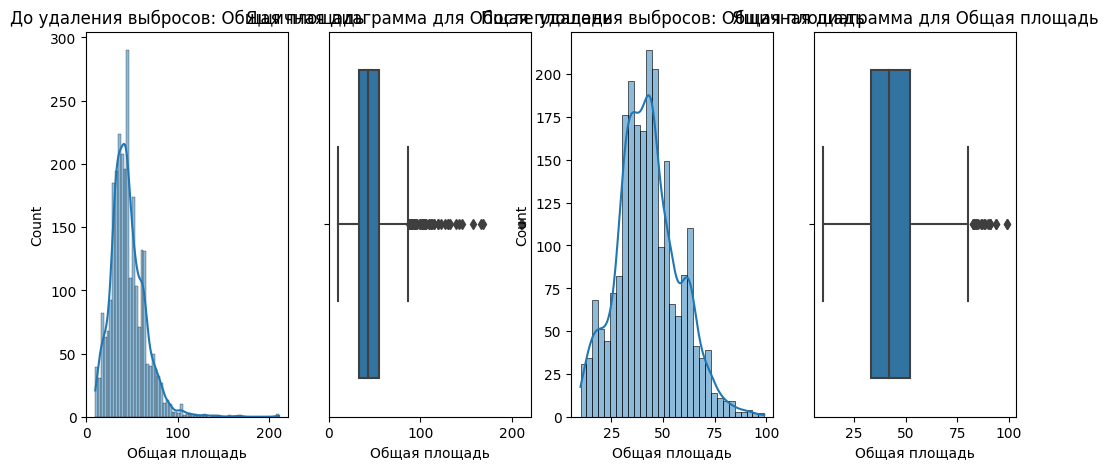

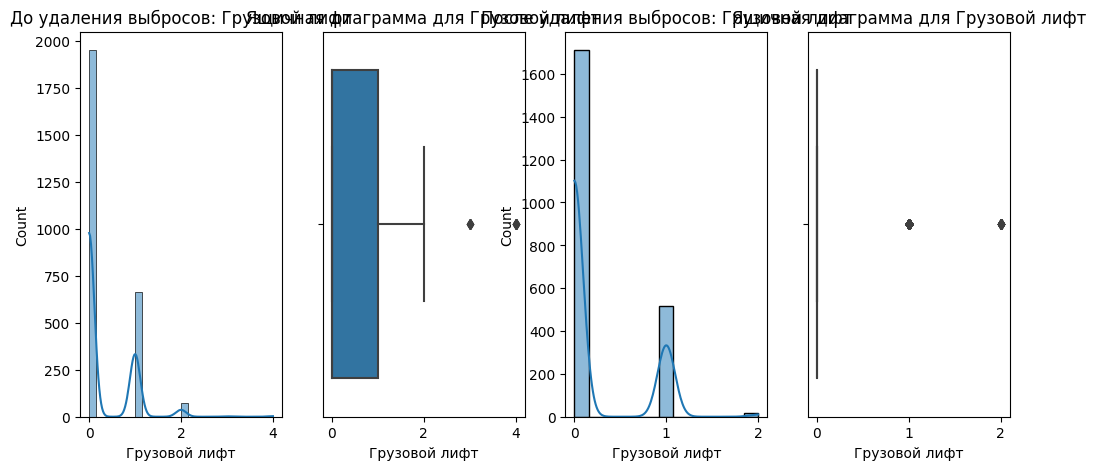

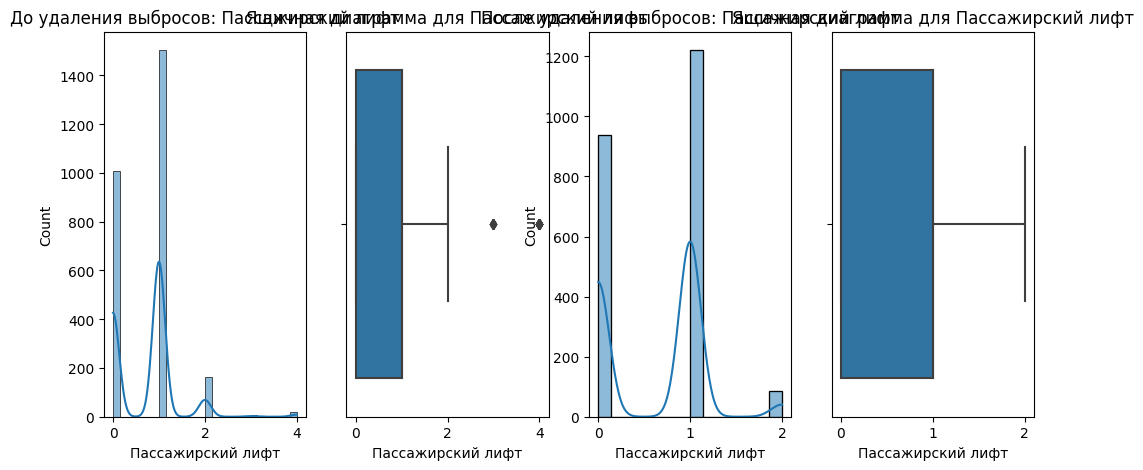

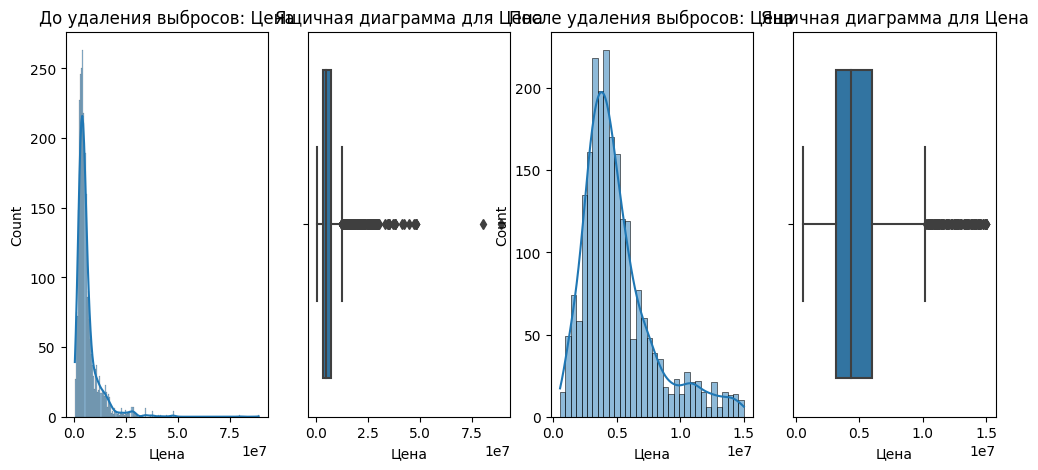

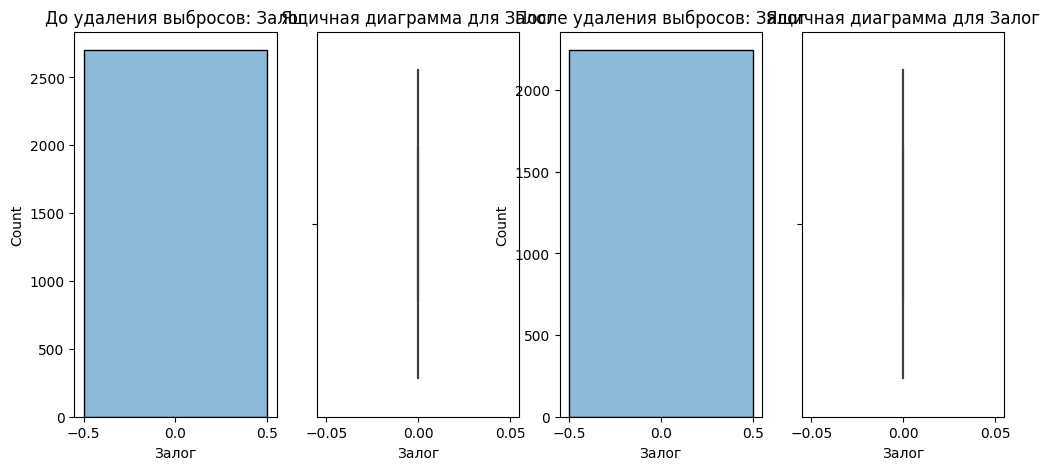

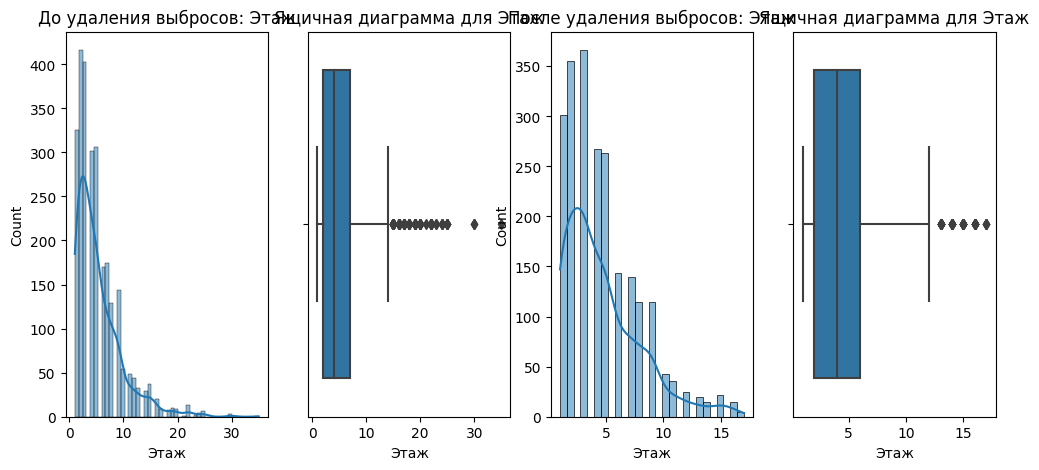

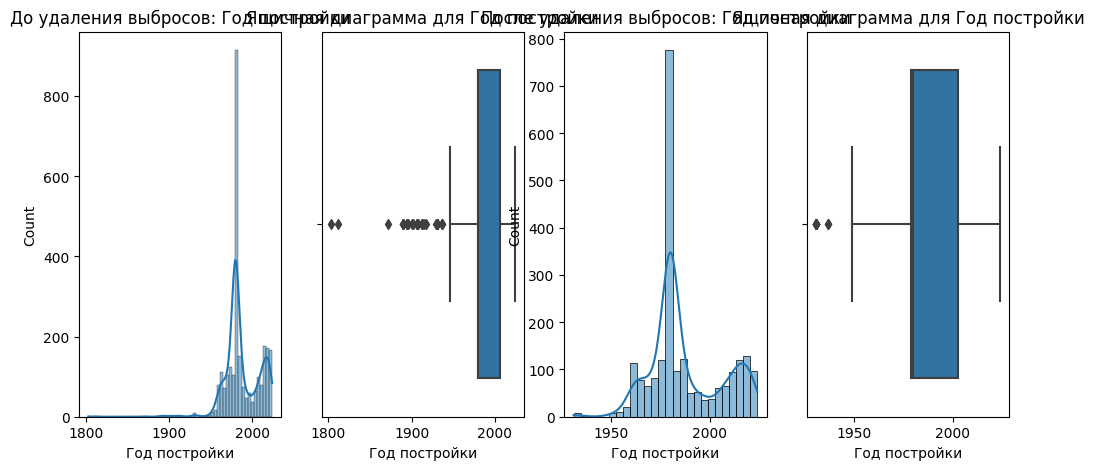

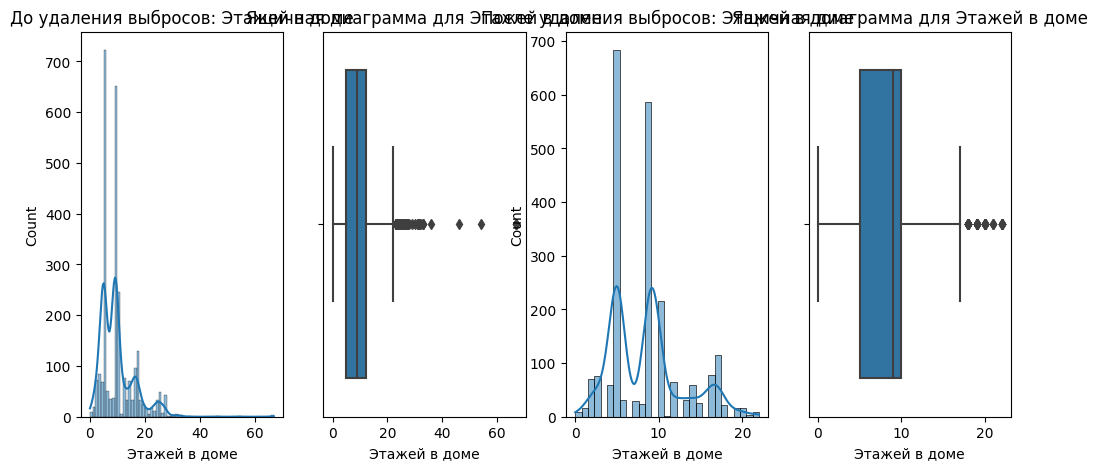

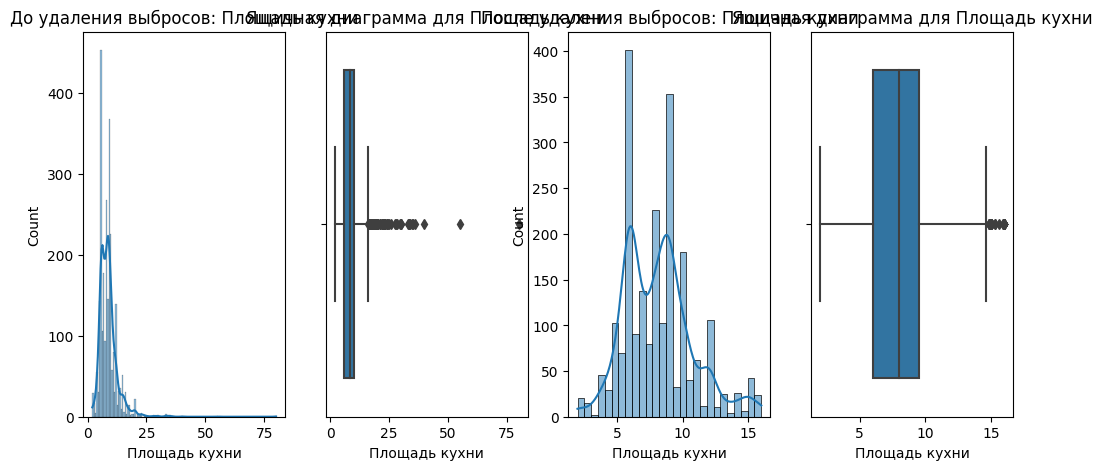

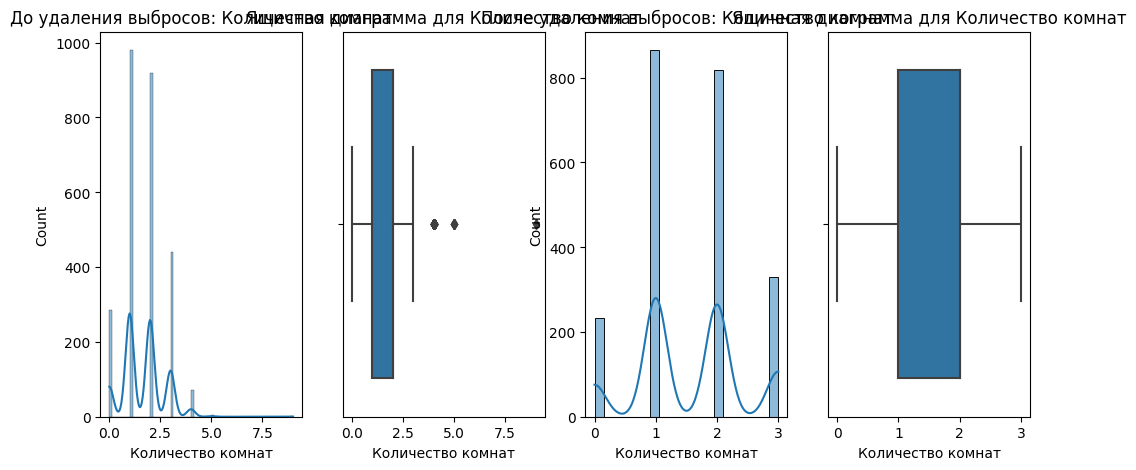

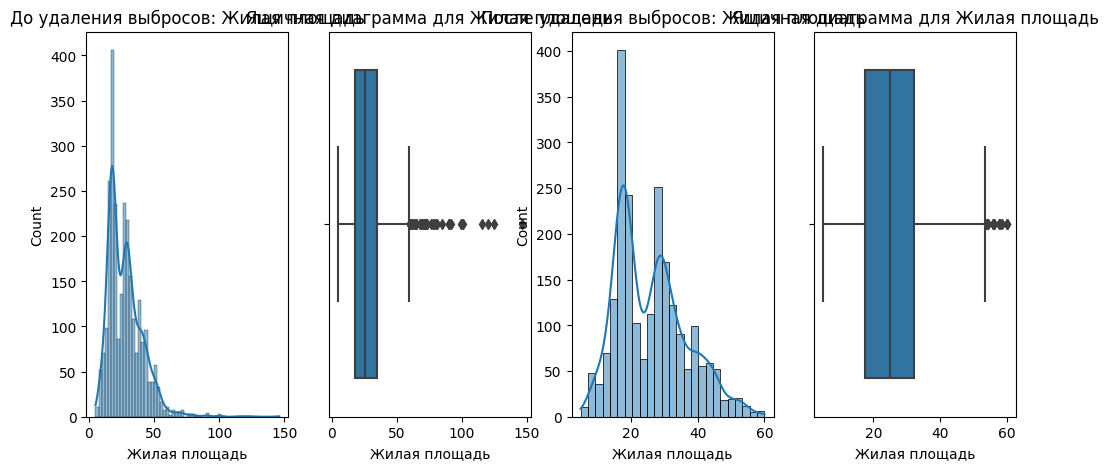

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Пример для одной переменной (можно применить в цикле для всех числовых переменных)
for col in numerical_columns:
    plt.figure(figsize=(12, 5))

    # Гистограмма до удаления выбросов
    plt.subplot(1, 4, 1)
    sns.histplot(newData[col], kde=True)
    plt.title(f'До удаления выбросов: {col}')
    
	
    
    # Ящичная диаграмма для поиска выбросов
    plt.subplot(1, 4, 2)
    sns.boxplot(x=newData[col])
    plt.title(f'Ящичная диаграмма для {col}')

    # Гистограмма после удаления выбросов
    plt.subplot(1, 4, 3)
    sns.histplot(data_filtered[col], kde=True)
    plt.title(f'После удаления выбросов: {col}')
    
    # Ящичная диаграмма для поиска выбросов
    plt.subplot(1, 4, 4)
    sns.boxplot(x=data_filtered[col])
    plt.title(f'Ящичная диаграмма для {col}')

    plt.show()


 1. **Анализ выбросов**
   - На первоначальных графиках распределения видно значительное количество выбросов, особенно заметных на ящичных диаграммах. Эти выбросы искажают данные, приводя к появлению экстремальных значений, которые могут сбивать модель с толку.
   - После удаления выбросов ящичные диаграммы показывают гораздо меньше экстремальных точек, что указывает на более чистый набор данных с меньшим количеством шумов. Это изменение помогает избежать переобучения модели на редкие, экстремальные значения, которые плохо обобщаются на реальных данных.

 2. **Модели распределения**
   - Основные гистограммы распределения после удаления выбросов демонстрируют более нормализованное распределение ключевых признаков. Ранее редкие события (резкие пики) растягивали гистограммы, создавая иллюзию определённого типа зависимости (например, квадратичной вместо линейной).
   - Без выбросов паттерны становятся более чёткими. Например, становится заметнее линейная или экспоненциальная зависимость для таких признаков, как `Цена` и `Общая площадь`, что упростит моделирование и предсказание тенденций.

 3. **Значительные изменения в ключевых признаках**
   - **`Цена`:** Ранее на распределение цены сильно влияли экстремальные значения, что делало его неравномерным. После фильтрации распределение цены стало ближе к основным данным, что улучшает точность предсказаний модели для этого признака.
   - **`Общая площадь`, `Жилая площадь`, `Площадь кухни`:** Удаление выбросов для этих признаков устранило маловероятные значения, делая распределение площадей более реалистичным. Это улучшение помогает лучше понять диапазоны площадей, которые могут коррелировать с ценой.
   - **`Год постройки`:** После удаления выбросов распределение годов постройки акцентируется на типичных временных рамках, вероятно, между 1950 и 2000 годами. Этот диапазон представляет большинство объектов недвижимости, убирая шум от редких случаев крайне старых или новых зданий, которые могли искажать предсказания.

 4. **Улучшение плотности и точности в других столбцах**
   - **`Этажей в доме` и `Количество комнат`:** Удаление выбросов увеличивает плотность распределения вокруг типичных значений. Это значит, что данные стали представлять более реалистичные, распространённые конфигурации (например, типичное количество комнат и этажность зданий), что, вероятно, улучшит производительность модели на стандартных объектах недвижимости.
   - Снижение количества единичных точек (выбросов) в этих категориях также позволяет модели сосредоточиться на более вероятных случаях, улучшая её способность к обобщению и избегая редких конфигураций, которые могут искажать предсказания.

 5. **Конфигурационная структура данных**
   - Конфигурационная структура для обработки выбросов позволяет настраивать чистку данных, облегчая балансировку присутствия выбросов в зависимости от целей модели. Это обеспечивает гибкость, позволяя оптимизировать набор данных для разных моделей (например, строгая чистка для линейных моделей или более лояльный подход для более устойчивых алгоритмов).

#### **Ключевые выводы**
   - Удаление выбросов по различным признакам уточняет зависимости, усиливает релевантность основных трендов и улучшает читаемость данных для модели. Особенно сильно это повлияло на признаки `Цена`, `Площадь` и `Год постройки`, которые получили больше пользы от уменьшения шума.
   - Сосредоточившись на типичных значениях, диаграммы стали более репрезентативными для реальных зависимостей, что способствует более точным предсказаниям.

### Принятие изменений

In [54]:
newData = data_filtered

In [55]:
# for col in numerical_columns:
#     Q1 = newData[col].quantile(0.25)
#     Q3 = newData[col].quantile(0.75)
#     IQR = Q3 - Q1
#     newData = newData[~((data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR)))]


## Анализ данных

Подгрузка данных для дебага, чтобы не ожидать выполнения команд выше

In [56]:
# Загрузка данных
analyze_data = pd.read_csv(debug_file_path)  # Укажите путь к файлу

### Корелляционная таблица

<AxesSubplot: >

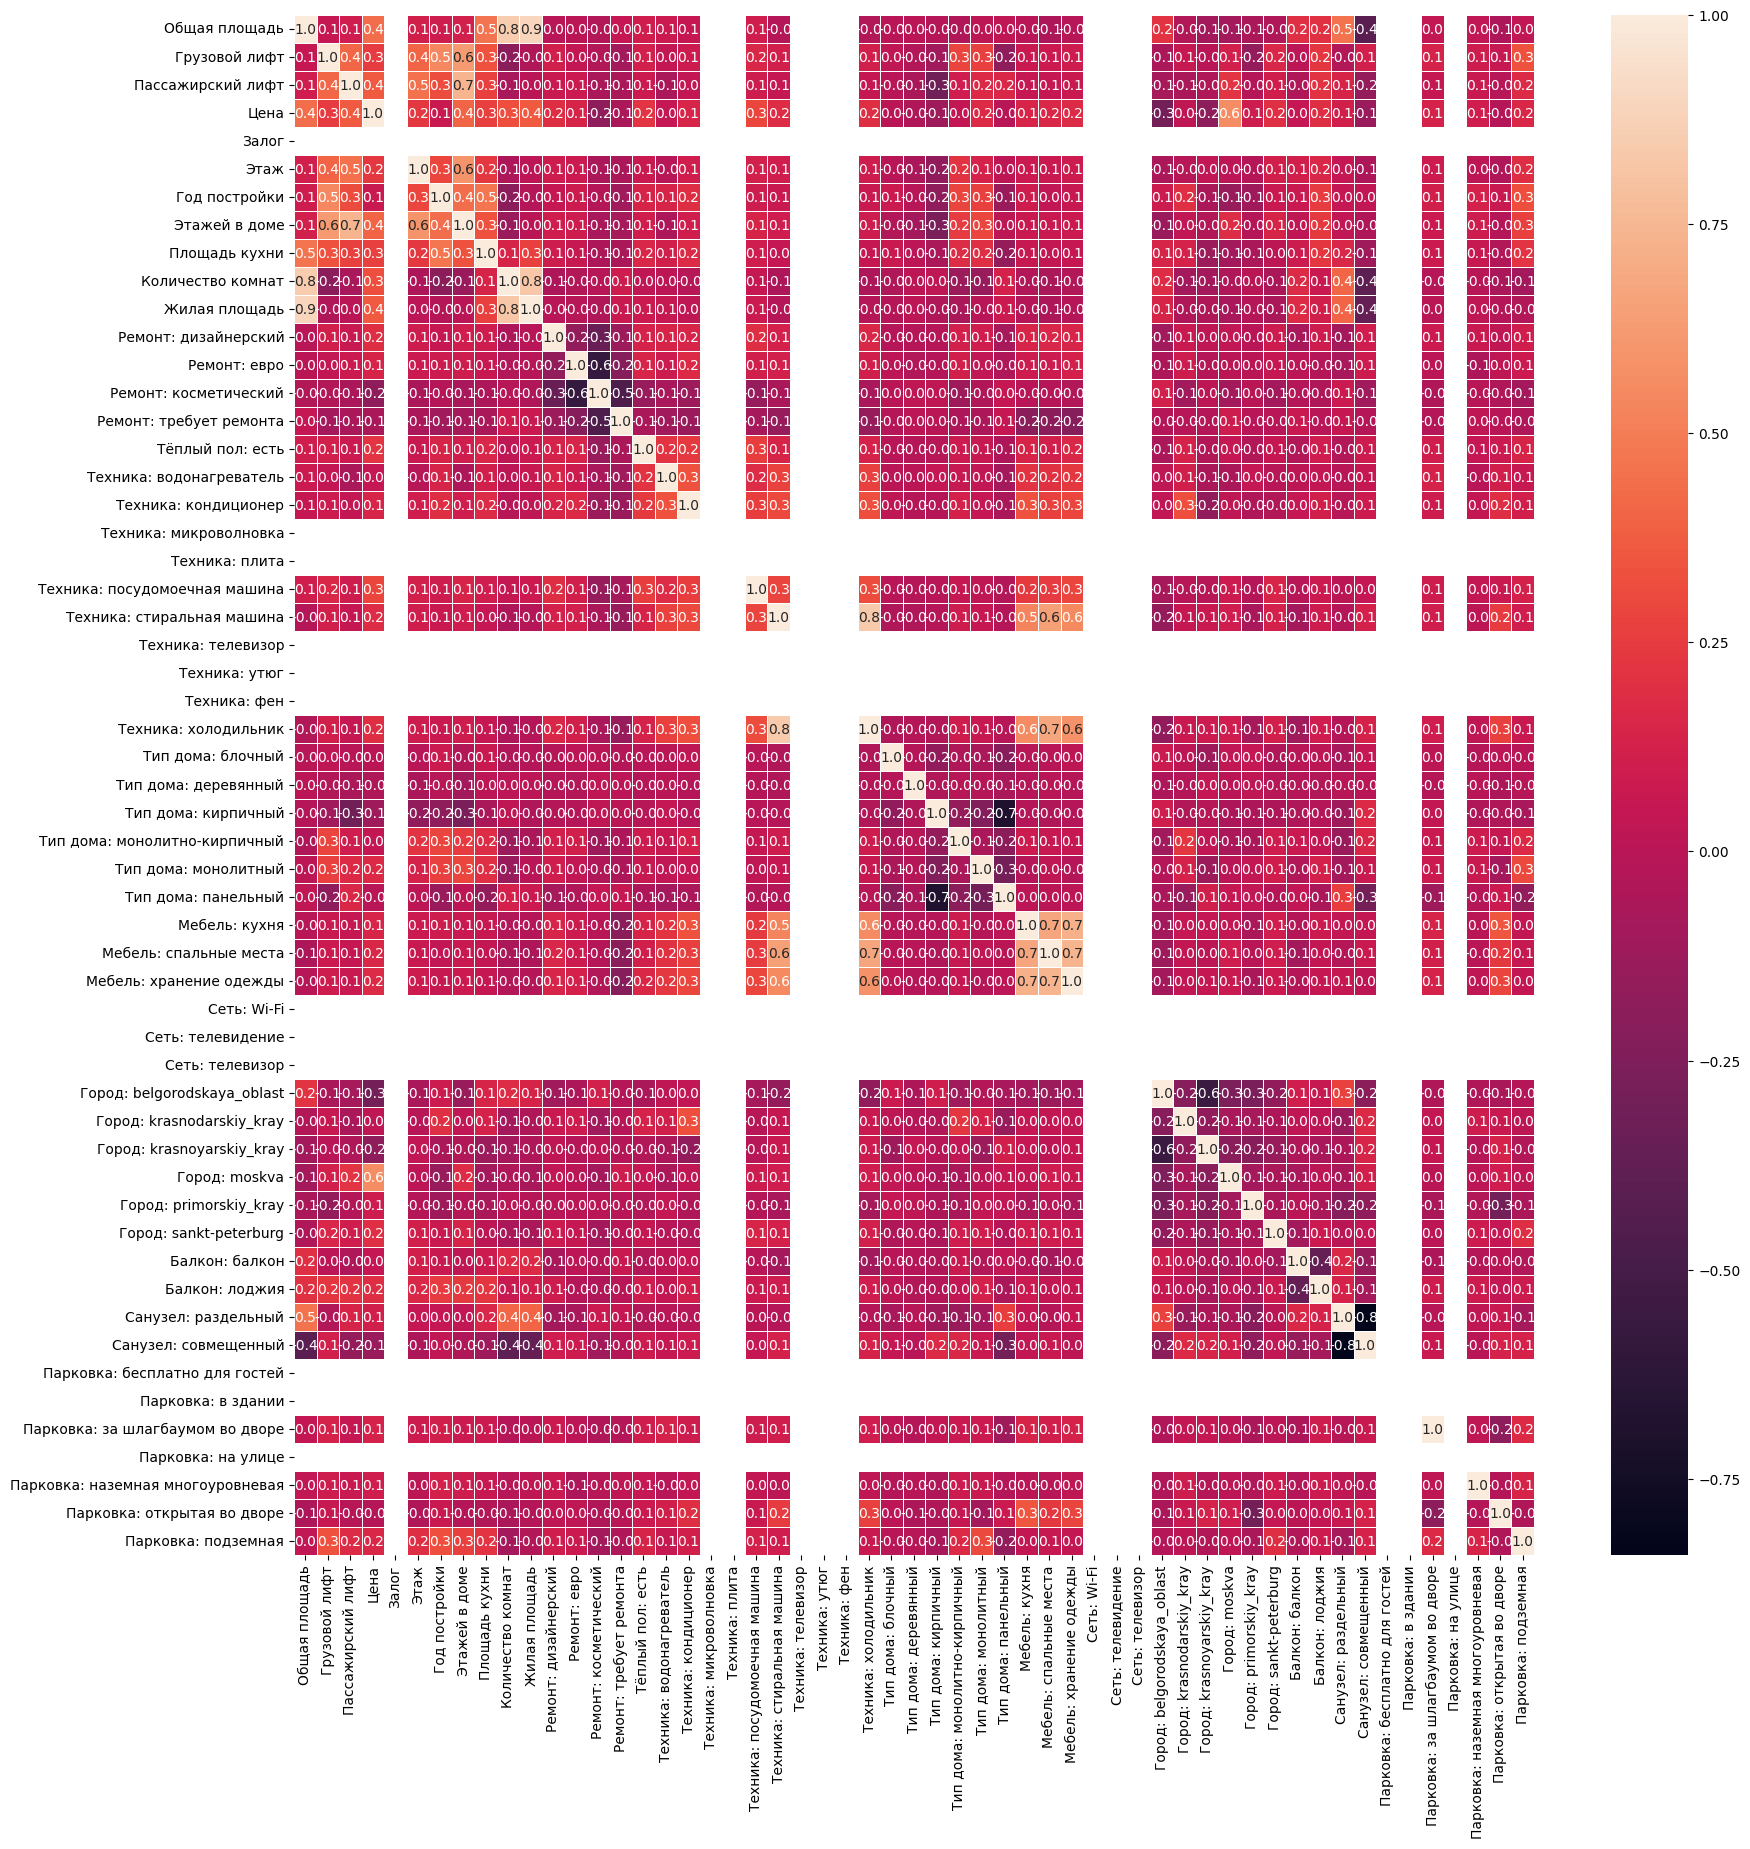

In [57]:
cor_mat=newData.corr()
fig,ax=plt.subplots(figsize=(20,20))
sns.heatmap(cor_mat,annot=True,linewidths=0.5,fmt="0.1f")

#### Анализ корреляционной матрицы

Корреляционная матрица, представленная на изображении, показывает, какие признаки набора данных связаны друг с другом и насколько сильно. Вот ключевые наблюдения по матрице:

1. **Высокая корреляция между `Общей площадью` и `Жилой площадью`**:
   - Видна высокая корреляция между общей и жилой площадью. Это логично, так как жилая площадь является частью общей площади, и увеличение одной обычно означает увеличение другой.
   - Это может помочь модели понять, что оба признака описывают схожие характеристики и могут усиливать друг друга при моделировании цены или других зависимостей.

2. **Связь между `Этажами в доме` и `Этаж`**:
   - Умеренная корреляция между этажом квартиры и количеством этажей в доме. Это может указывать на тенденцию для высоких зданий включать квартиры на больших этажах, и наоборот.
   - Этот признак может быть полезен для определения факторов, влияющих на цену или популярность объектов.

3. **Корреляция `Цена` и других признаков**:
   - `Цена` показывает положительную корреляцию с такими признаками, как `Общая площадь`, `Жилая площадь` и `Количество комнат`, что логично, так как более крупные объекты обычно стоят дороже.
   - Корреляция с `Этаж` и `Этажами в доме` более слабая, но всё же заметна, что может означать определённое влияние этажности и высоты здания на стоимость недвижимости.

4. **Связь между `Типом дома` и `Годом постройки`**:
   - Корреляция между типом дома (например, кирпичный, панельный) и годом постройки. Это объясняется тем, что разные технологии строительства были популярны в разные исторические периоды.
   - Например, панельные дома могли строиться преимущественно в определённые годы, что создаёт зависимость между типом материала и годом постройки.

5. **Корреляции между элементами инфраструктуры и признаками комфорта**:
   - Некоторые признаки, такие как наличие парковки или определённого типа балкона, имеют слабую корреляцию друг с другом, что может быть связано с различиями в планировке и инфраструктуре.
   - Эти признаки могут указывать на социальные и инфраструктурные различия между типами жилья и районами.

6. **Практическое значение для модели**:
   - Из этой корреляционной матрицы можно выделить признаки с высокой корреляцией и рассмотреть их для возможного удаления или объединения, чтобы избежать мультиколлинеарности в модели.
   - Например, объединение `Общей площади` и `Жилой площади` может снизить избыточность и упростить модель, оставив важные факторы без потери информации.

#### Выводы

- **Основные зависимости** между площадью и ценой подтверждают логичность данных и могут быть использованы для улучшения модели.
- **Типовые корреляции**, такие как год постройки и тип дома, дают представление о возможной сегментации по типу и периоду строительства, что также полезно для анализа.
- **Анализ инфраструктурных признаков** указывает на потенциальные социальные и удобные факторы, влияющие на предпочтения пользователей.


### Распределения количественных признаков

In [58]:
numeric_columns = ['Общая площадь', 'Цена', 'Этаж', 'Год постройки', 'Площадь кухни', 'Количество комнат']
numerical_columns = numerical_columns.drop('Залог')

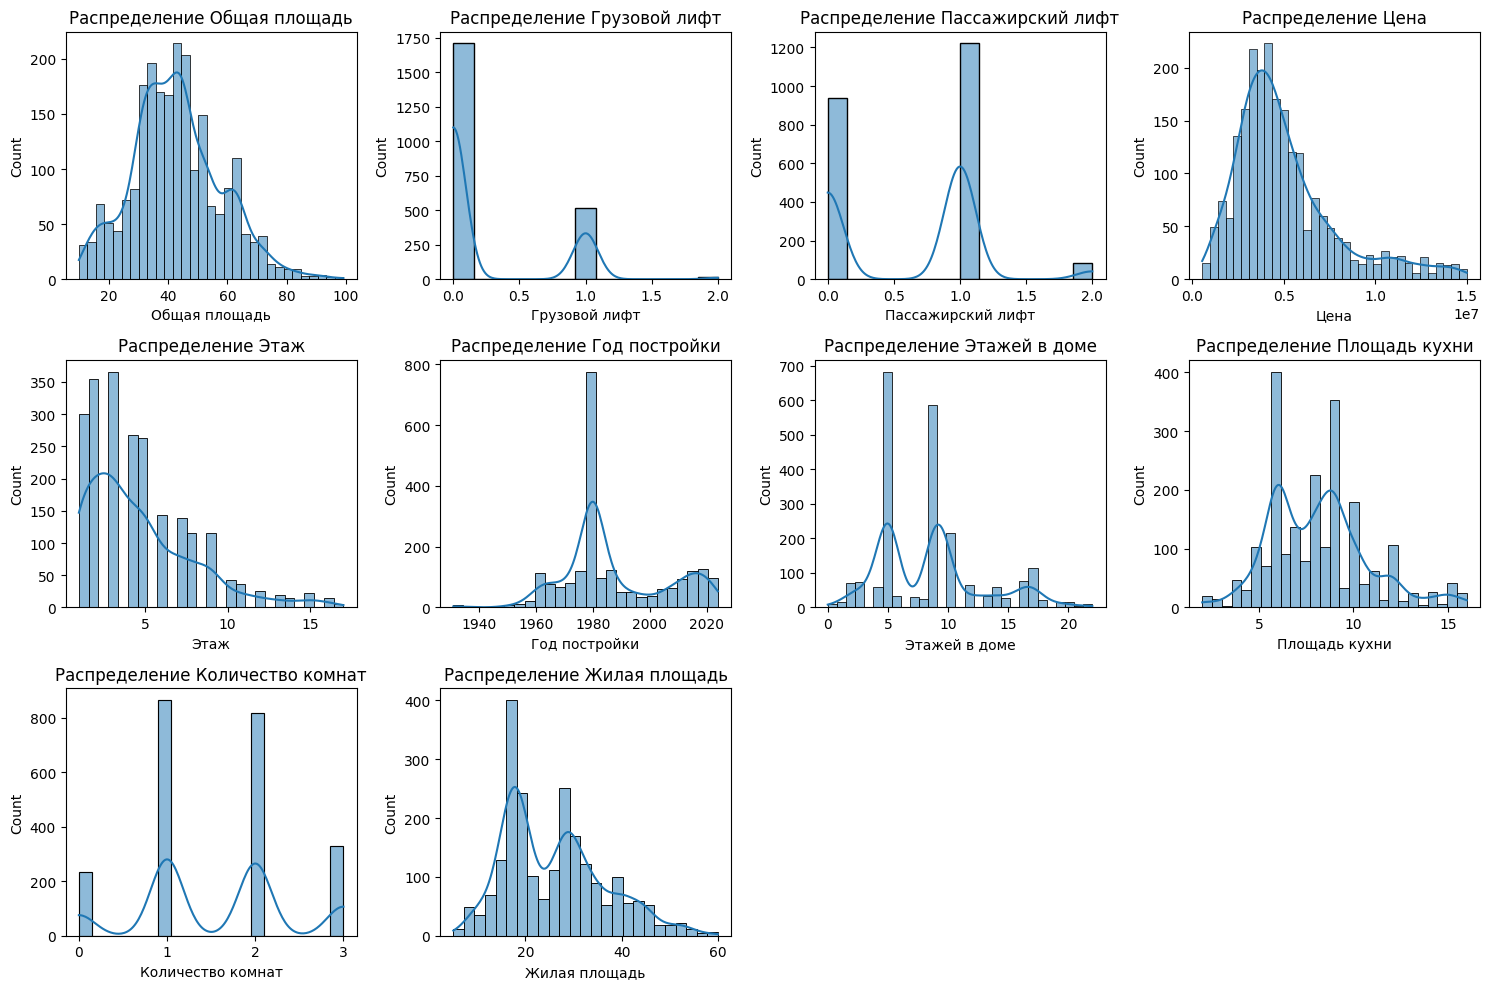

In [59]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 4, i)
    sns.histplot(analyze_data[col], kde=True)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

1. **Общая площадь**:
   - Большинство квартир имеют площадь от 30 до 60 кв.м, с пиком около 40 кв.м. Площадь больше 80 кв.м встречается редко.

2. **Грузовой лифт и Пассажирский лифт**:
   - Большая часть зданий либо не имеет лифта, либо оснащена одним пассажирским лифтом.
   - Количество зданий с двумя лифтами (грузовым или пассажирским) минимально.

3. **Цена**:
   - Основной ценовой диапазон для квартир — от 2 до 6 миллионов, с пиком примерно на уровне 4 миллионов.
   - Выше 6 миллионов предложения реже, хотя доходят и до 15 миллионов.

4. **Этаж**:
   - Наиболее популярны нижние этажи (1–5), после чего количество квартир на более высоких этажах постепенно уменьшается.

5. **Год постройки**:
   - Наибольшая концентрация — здания, построенные в 1980-х годах. Здания, построенные до 1960-х и после 2000-х, встречаются реже.

6. **Этажей в доме**:
   - Пики распределения наблюдаются для домов с 5 и 9 этажами, что может быть связано с распространенными типами построек в разные годы.

7. **Площадь кухни**:
   - Основной диапазон — от 5 до 10 кв.м, что указывает на средние размеры кухонь. Есть также небольшое количество квартир с более крупными кухнями (>15 кв.м).

8. **Количество комнат**:
   - Преобладают квартиры с 1 и 2 комнатами, с отчетливыми пиками. 3-комнатные квартиры встречаются реже, но также популярны.

9. **Жилая площадь**:
   - Основная масса жилой площади варьируется от 15 до 40 кв.м, что коррелирует с общей площадью. Более крупные квартиры редки.


### Корреляции между количественными признаками

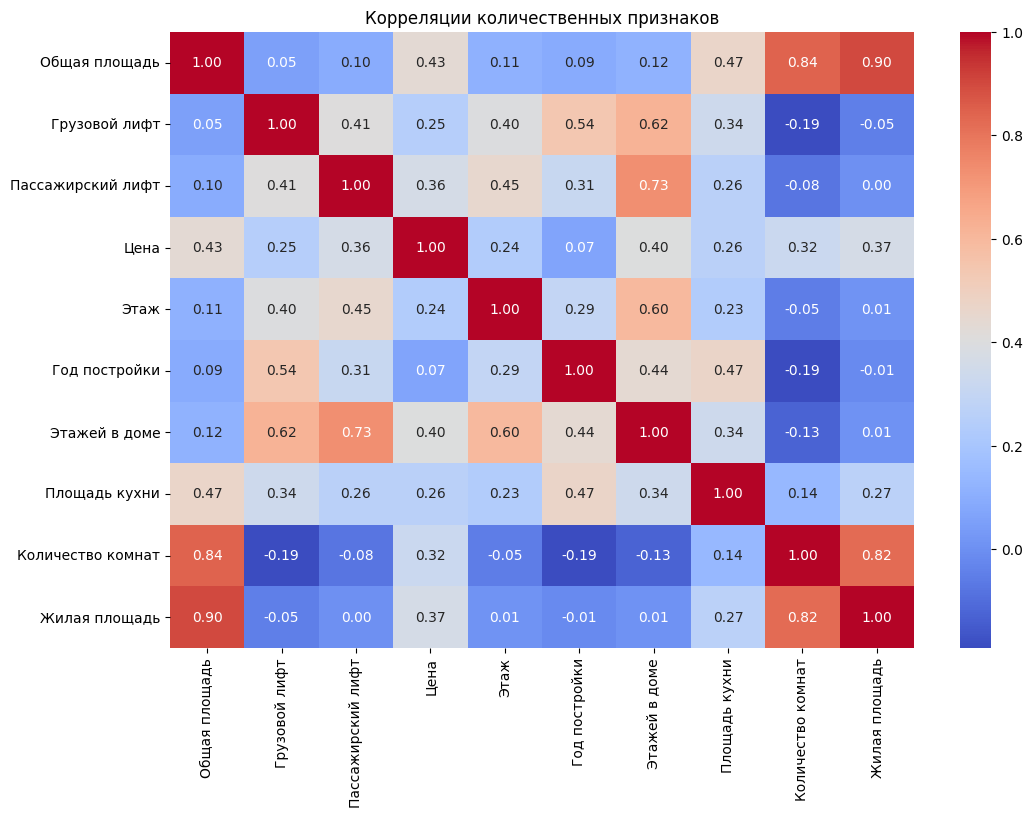

In [60]:
plt.figure(figsize=(12, 8))
correlation_matrix = analyze_data[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Корреляции количественных признаков")
plt.show()

1. **Сильная корреляция между `Общей площадью` и `Жилой площадью`**:
   - Коэффициент корреляции составляет 0.90, что логично, так как жилая площадь является частью общей площади. Учитывая высокую взаимосвязь, возможно, один из этих признаков можно исключить в модели, чтобы избежать мультиколлинеарности.

2. **Связь между `Общей площадью` и `Количество комнат`**:
   - Коэффициент 0.84 говорит о том, что с увеличением площади растет и количество комнат. Это также вполне логично для жилой недвижимости.

3. **Корреляция `Этажей в доме` с `Пассажирским лифтом` и `Грузовым лифтом`**:
   - Видна умеренная корреляция (0.73 и 0.62 соответственно), что свидетельствует о том, что в более высоких зданиях чаще присутствуют лифты.

4. **Взаимосвязь между `Годом постройки` и `Грузовым лифтом`**:
   - Корреляция 0.54 указывает, что новые здания чаще оснащаются грузовыми лифтами, что может отражать современные строительные стандарты.

5. **Связь `Площади кухни` с `Общей площадью` и `Жилой площадью`**:
   - Корреляция с `Общей площадью` — 0.47, а с `Жилой площадью` — 0.27, что говорит о тенденции увеличения площади кухни с ростом общей площади квартиры, но эта связь не такая сильная, как у других параметров.

6. **Отсутствие значимой корреляции для некоторых признаков**:
   - `Этаж` и `Год постройки` имеют низкие корреляции с большинством других признаков, что говорит о том, что они менее связаны с параметрами квартиры и могут влиять на стоимость жилья независимо.

#### Итог
Эта корреляционная матрица позволяет выделить зависимые признаки, такие как `Общая площадь`, `Жилая площадь`, и `Количество комнат`, а также подчеркивает особенности современных строений (лифты в высоких зданиях, связь года постройки с наличием грузового лифта).

### Взаимосвязи между парными признаками

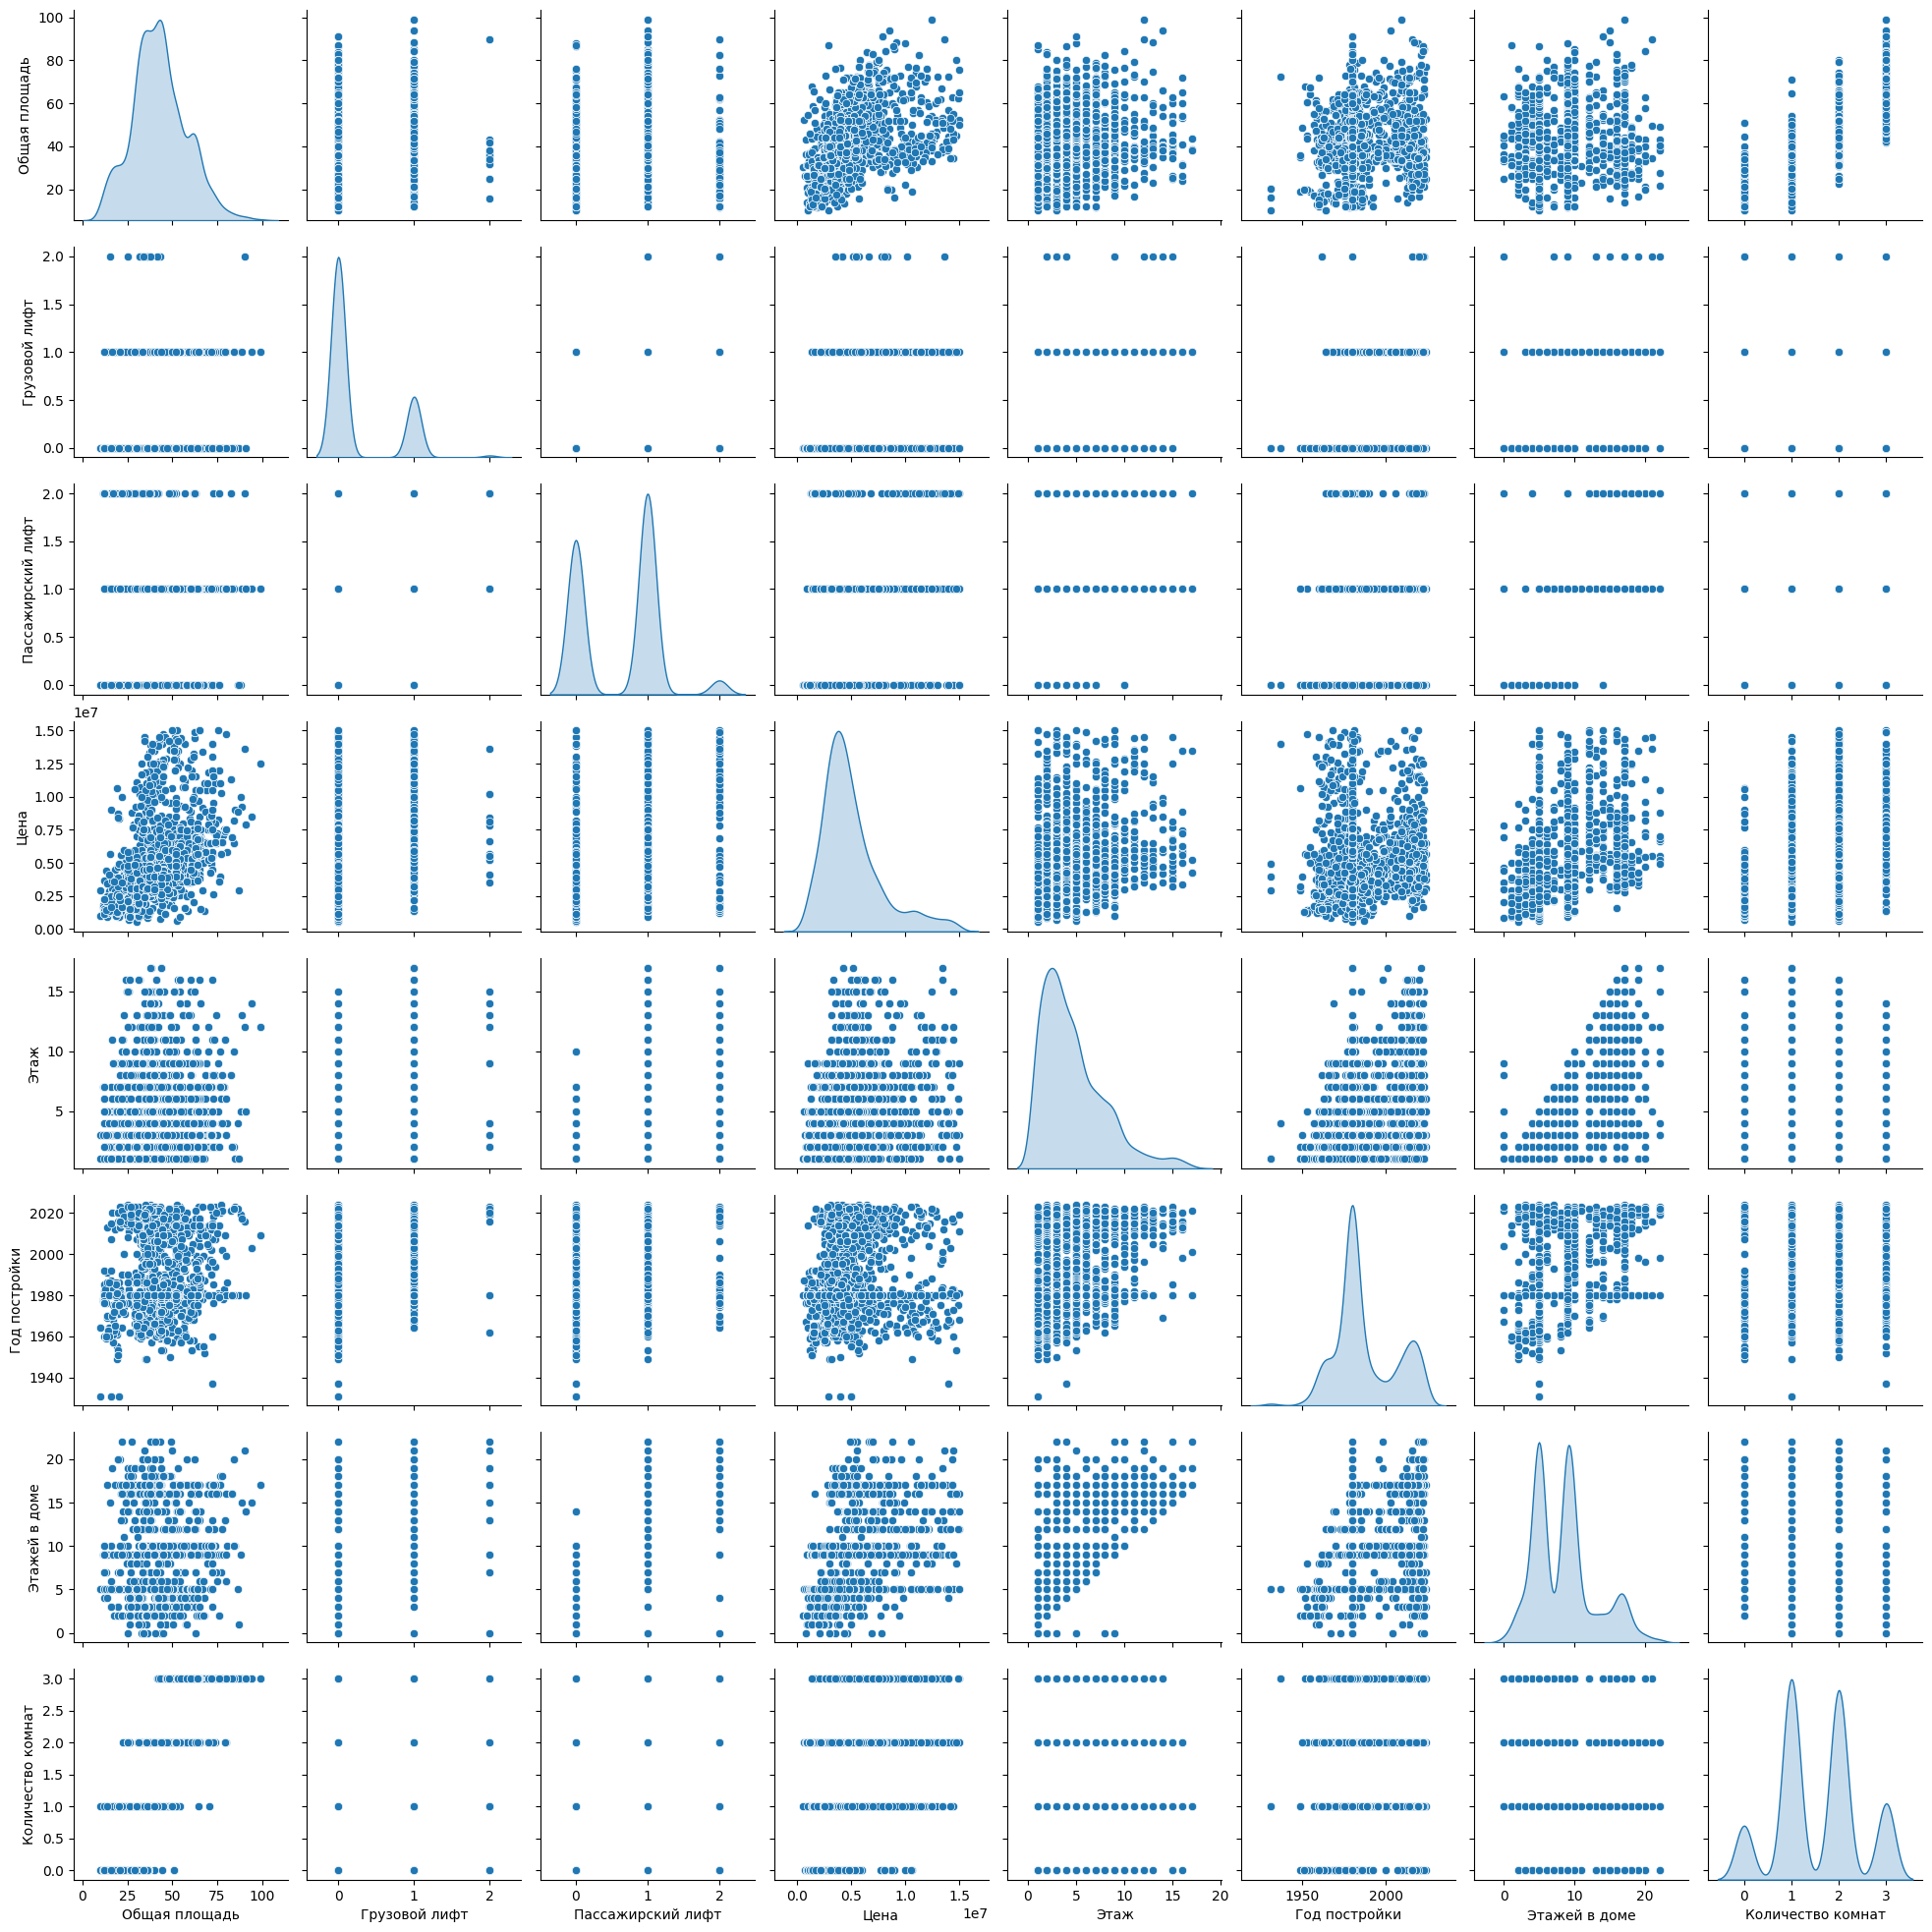

In [61]:
sns.pairplot(analyze_data[numerical_columns.drop('Жилая площадь').drop('Площадь кухни')], diag_kind='kde')
plt.show()

1. **Общая площадь и Цена**
   - На графике видно, что между общей площадью и ценой существует положительная зависимость: с увеличением площади цена также возрастает. Однако, данные распределены довольно размыто, без ярко выраженных кластеров. В этом случае модели кластеризации могут объединить эти данные в один кластер с небольшой плотностью или выделить некоторые небольшие подгруппы, связанные с ценой выше среднего. Однако, в целом данные тяготеют к одному основному кластеру.

2. **Этаж и Этажей в доме**
   - Распределение между этажом квартиры и этажностью здания также не образует явных кластеров. Большая часть точек сконцентрирована на нижних этажах в зданиях до 10 этажей. Однако, явных подгрупп или кластеров здесь также не наблюдается, что усложняет разделение на группы по этому признаку. DBSCAN может попытаться выделить отдельные плотные группы на нижних этажах, но это не создаст значимых кластеров.

3. **Год постройки**
   - График года постройки показывает, что большая часть зданий построена между 1960 и 2000 годами, но разброс по остальным периодам также присутствует. Это означает, что год постройки может быть слишком разбросанным для создания устойчивых кластеров. В этом случае алгоритм кластеризации может выделить небольшой кластер для современных зданий (после 2000 года), но этого недостаточно для формирования значимых групп. DBSCAN или иерархическая кластеризация могут помочь выделить данные по годам, но без явного деления на кластеры.

4. **Площадь кухни и Жилая площадь**
   - Здесь также видна положительная корреляция, но без чётко разделённых кластеров. Как и в случае с общей площадью и ценой, большая часть данных находится в пределах средней жилой площади и кухонь, что также приведёт к единому кластеру при попытке кластеризации. Подгруппы могут быть лишь условными, связаны с более крупной площадью, но они не создадут значимых кластеров.

5. **Количество комнат**
   - Плотное распределение значений по количеству комнат (1–3) также не создаёт визуально чётких кластеров. Большинство данных сосредоточено на 1-2 комнатах, что при кластеризации приведёт к одному большому кластеру с доминирующим числом небольших квартир. Алгоритмы могут выделить несколько редких случаев, таких как квартиры с большим количеством комнат, но это не будет представлять значимых кластеров.

6. **Лифты (Грузовой и Пассажирский)**
   - Лифты также не образуют значимых кластеров, так как значительное количество данных имеет значение 0 (отсутствие лифта), и только небольшое число данных указывает на наличие лифтов. Это распределение приведёт к объединению данных в единый кластер, где большинство объектов не имеет лифтов, и выделения нескольких небольших подгрупп с лифтами, что опять-таки не создаёт значимых кластеров.

#### Заключение
В целом, данные, представленные на графиках, действительно склоняются к объединению в один основной кластер. Попытка разбить их на кластеры, вероятно, приведёт к слабым подгруппам, связанным с:
   - Высокой ценой и большой площадью,
   - Недавними годами постройки,
   - Большим количеством этажей и этажностью здания.

Для создания более выразительных кластеров, возможно, стоит использовать методы понижения размерности. 

### Анализ категориальных признаков

In [62]:
drop_categorical_list = ['Техника: микроволновка', 'Техника: плита', 'Техника: телевизор', 'Техника: утюг', 'Техника: фен', 'Сеть: Wi-Fi',
       'Сеть: телевидение', 'Сеть: телевизор', 'Парковка: бесплатно для гостей', ]
categotical_columns_OH = newData.columns.drop(numerical_columns).drop('Залог').drop(drop_categorical_list)
categotical_columns_OH

Index(['Ремонт: дизайнерский', 'Ремонт: евро', 'Ремонт: косметический',
       'Ремонт: требует ремонта', 'Тёплый пол: есть',
       'Техника: водонагреватель', 'Техника: кондиционер',
       'Техника: посудомоечная машина', 'Техника: стиральная машина',
       'Техника: холодильник', 'Тип дома: блочный', 'Тип дома: деревянный',
       'Тип дома: кирпичный', 'Тип дома: монолитно-кирпичный',
       'Тип дома: монолитный', 'Тип дома: панельный', 'Мебель: кухня',
       'Мебель: спальные места', 'Мебель: хранение одежды',
       'Город: belgorodskaya_oblast', 'Город: krasnodarskiy_kray',
       'Город: krasnoyarskiy_kray', 'Город: moskva', 'Город: primorskiy_kray',
       'Город: sankt-peterburg', 'Балкон: балкон', 'Балкон: лоджия',
       'Санузел: раздельный', 'Санузел: совмещенный', 'Парковка: в здании',
       'Парковка: за шлагбаумом во дворе', 'Парковка: на улице',
       'Парковка: наземная многоуровневая', 'Парковка: открытая во дворе',
       'Парковка: подземная'],
      dtype='

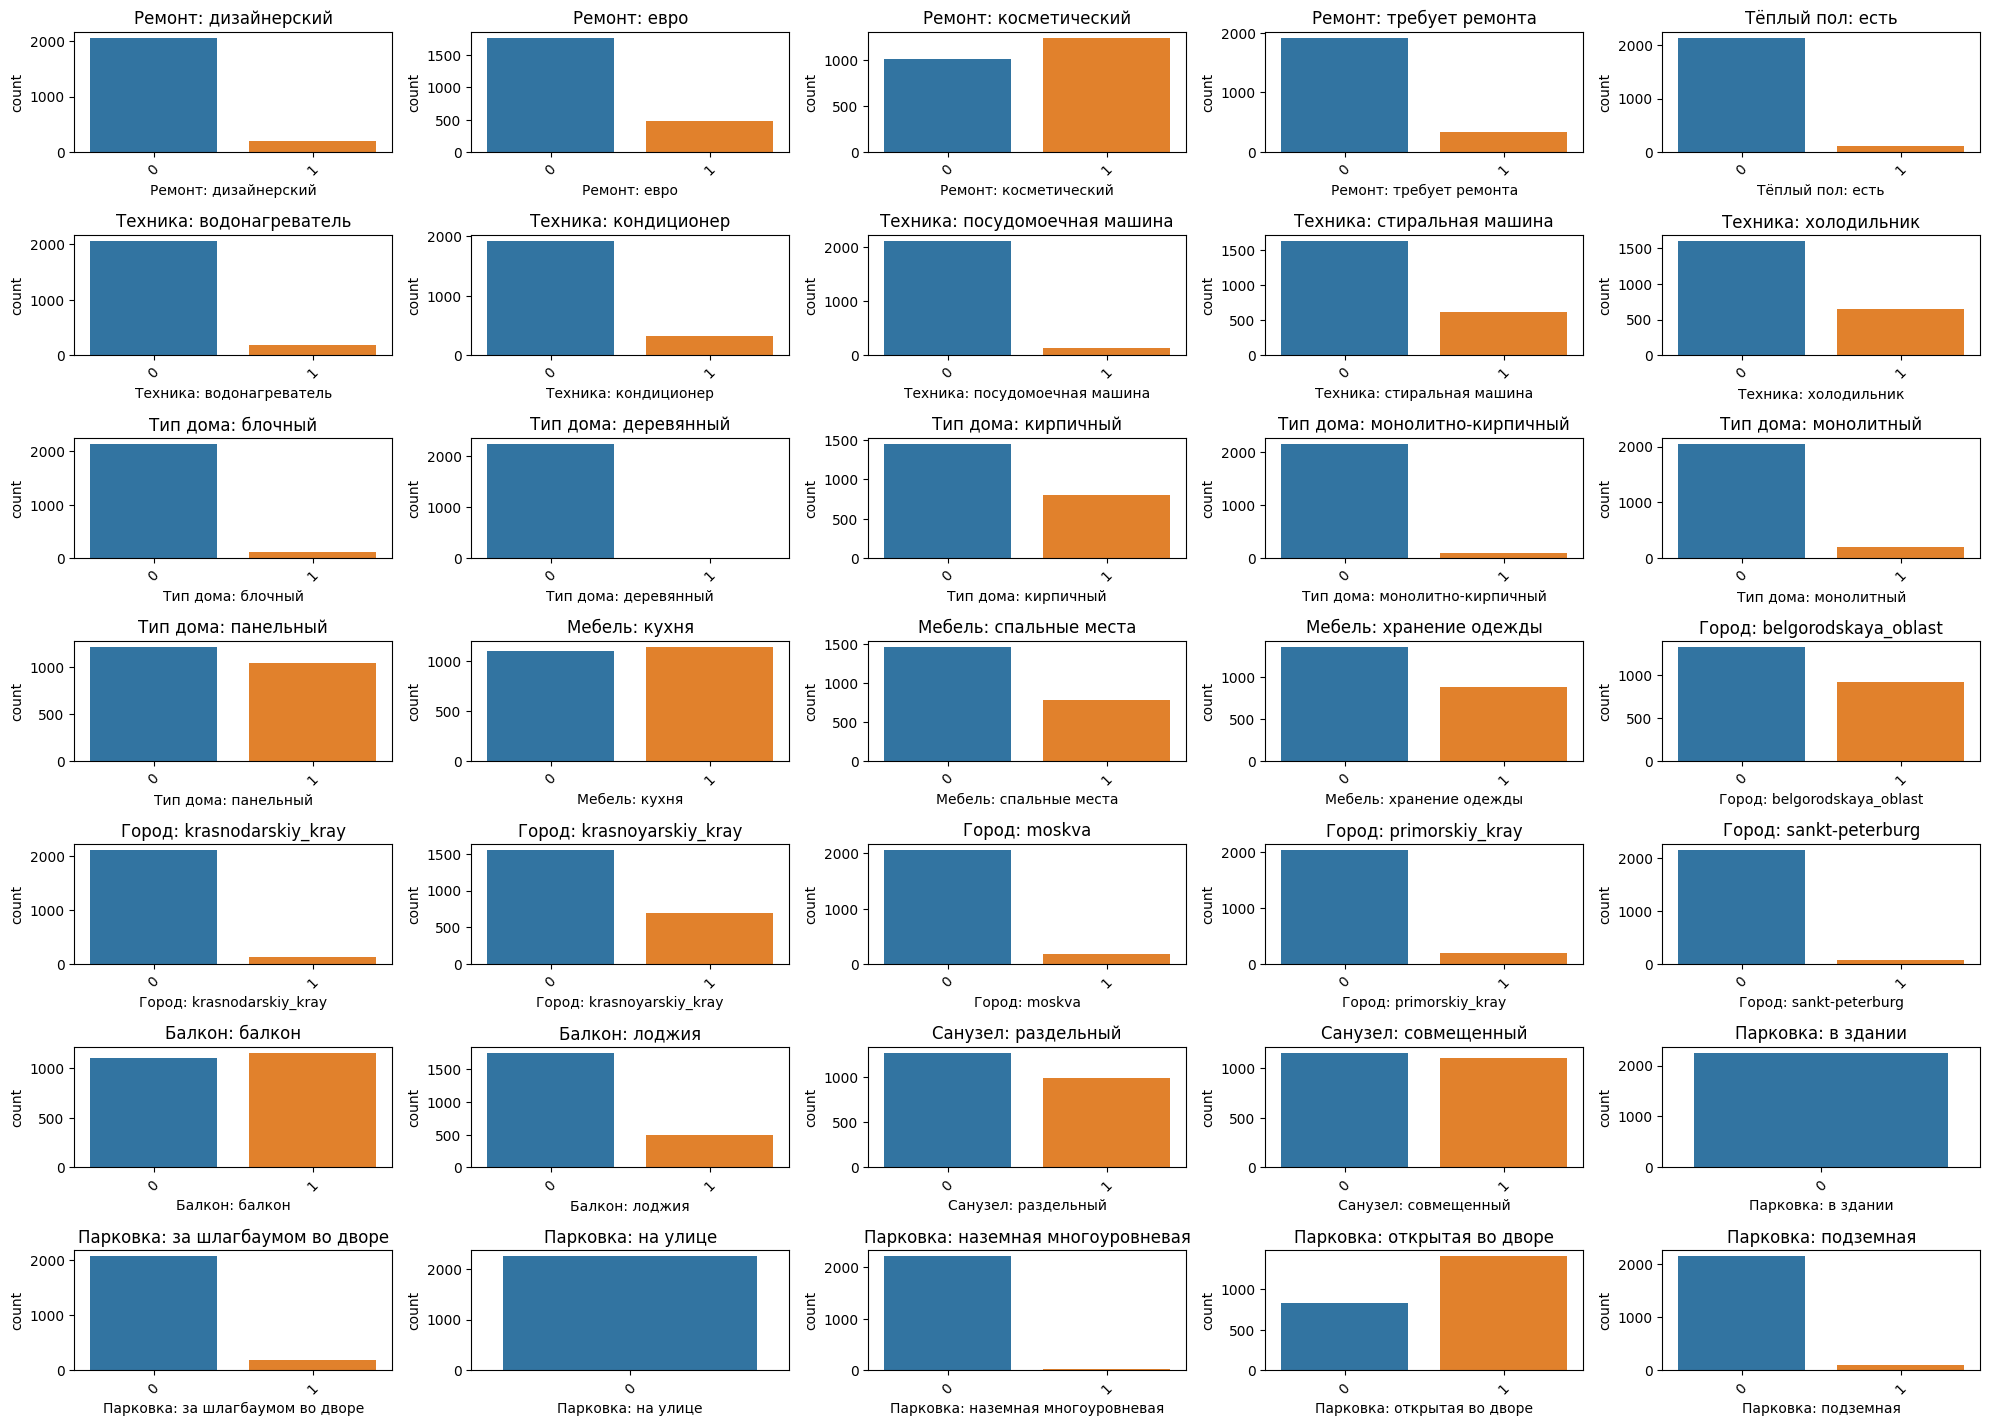

In [63]:
categoric_columns = ['Тип дома: кирпичный', 'Тип дома: панельный', 'Город: moskva', 'Город: sankt-peterburg']

plt.figure(figsize=(20, 20))
for i, col in enumerate(categotical_columns_OH, 1):
    plt.subplot(10, 5, i)
    sns.countplot(x=col, data=analyze_data)
    plt.title(f'{col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

 1. **Ремонт**
   - Большинство квартир не имеют дизайнерского, евроремонта или косметического ремонта. Преобладают стандартные типы отделки, или они вообще требуют ремонта. Категория “Требует ремонта” встречается довольно редко, что логично для рыночного предложения готового жилья.
   - Это указывает на то, что состояние ремонта в выборке сконцентрировано вокруг базовых или стандартных вариантов, что не создаёт сильного влияния на кластеризацию.

 2. **Техника**
   - Такие удобства, как водонагреватель, кондиционер, посудомоечная машина, стиральная машина, холодильник, не входят в стандартную комплектацию большинства квартир, что видно по незначительному числу квартир, где они представлены. 
   - При этом наличие стиральной машины и холодильника встречается чаще, что делает эти признаки слабыми для выделения кластеров, поскольку они типичны для большинства квартир.

 3. **Тип дома**
   - Панельные и блочные дома преобладают, что соответствует массовой застройке. Кирпичные и монолитные дома также присутствуют, но в меньшей доле, и, возможно, относятся к более современному или премиальному сегменту.
   - Этот признак может быть полезен для кластеризации, так как тип здания часто ассоциируется с различиями в цене и восприятии качества жилья.

 4. **Мебель**
   - Наличие кухонной мебели и мест для хранения (спальные места и шкафы для одежды) варьируется. Большинство квартир имеет хотя бы базовый набор мебели.
   - Этот признак может способствовать минимальному разделению на кластеры между полностью меблированными и частично пустыми квартирами, но значительного влияния на кластеризацию он не окажет.

 5. **Город**
   - На графиках показано, что большая часть данных относится к Москве, Санкт-Петербургу и Краснодарскому краю. Реже встречаются такие регионы, как Приморский край или Белгородская область.
   - Географическое расположение может быть хорошим фактором для кластеризации, так как цены и условия на рынке недвижимости сильно зависят от региона.

 6. **Балкон**
   - Наличие балкона/лоджии варьируется, но большая часть квартир всё же имеет хотя бы одну из этих опций.
   - Балкон сам по себе не создаёт значимых кластеров, так как квартиры с и без балкона примерно равномерно распределены.

 7. **Санузел**
   - Тип санузла (раздельный или совмещённый) также не показывает значимых различий, так как оба варианта встречаются в выборке. Это указывает на слабую ценность признака для кластеризации.

 8. **Парковка**
   - Различные виды парковки, такие как подземная, многоуровневая, уличная или за шлагбаумом, распределены неравномерно. Подземная и многоуровневая парковки встречаются реже, что характерно для более дорогого сегмента жилья.
   - Этот признак может быть полезен для выделения отдельных групп, так как наличие подземной парковки или охраняемой зоны может быть признаком премиальных квартир.

#### Заключение
Из категориальных признаков, представленных на графиках, **ключевые для кластеризации** будут: **Тип дома**, **Город** и **Парковка**. Эти параметры могут указать на различия в качестве и доступности недвижимости, что способствует выделению хотя бы небольших кластеров. Остальные признаки дают слабые возможности для разделения данных, так как либо слишком часто встречаются, либо равномерно распределены по выборке.

### PCA

#### Стандартизация **данных**

In [64]:
# Стандартизация данных
scaler = StandardScaler()
scaled_data = scaler.fit_transform(analyze_data[numerical_columns])
scaled_half_data = scaler.fit_transform(analyze_data[numeric_columns])

#### Применение PCA

In [65]:
# Применение PCA для снижения размерности до 2 компонентов
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

#### Визуализация в пространстве PCA

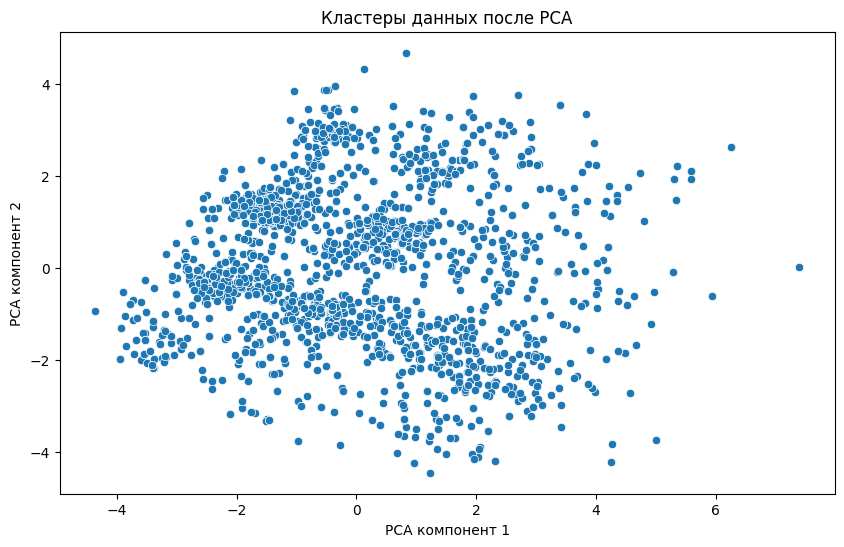

In [66]:
# Визуализация в пространстве PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], palette='Set1')
plt.title('Кластеры данных после PCA')
plt.xlabel('PCA компонент 1')
plt.ylabel('PCA компонент 2')
plt.show()

PCA позволяет свести многомерные данные к двум измерениям, чтобы упростить визуализацию и попытаться увидеть кластеры. Вот что можно отметить по графику:

1. **Распределение данных**
   - Большинство точек на графике сгруппированы вокруг центра, где-то между значениями -2 и 2 по обеим компонентам. Это указывает на плотное распределение данных в этом диапазоне, что подтверждает ранее сделанные выводы: данные склонны к формированию одного основного кластера, без ярко выраженных подгрупп.

2. **Отсутствие выраженных кластеров**
   - Несмотря на попытки выделить кластеры через понижение размерности, чёткие группы не проявляются. Это может означать, что данные действительно не имеют структурированных кластеров и более однородны, чем предполагалось. Такой результат характерен для данных, где большинство признаков плавно перетекают друг в друга, а резких границ между группами нет.

3. **Наличие небольших разреженных областей**
   - Хотя основные данные сосредоточены в центре, небольшое количество точек находится вдали от этой области (в пределах -4 и 4 по PCA-компонентам). Эти точки могут быть аномалиями или отдельными объектами с редкими сочетаниями признаков, но они не образуют самостоятельные кластеры.



#### Вывод
На данном этапе, по результатам PCA, можно заключить, что данные действительно склонны к одному основному кластеру, и четкие разделения между группами отсутствуют. Это может потребовать либо дополнительных инженерных решений с признаками, либо принятия того факта, что данные не имеют чётко выраженных структур для разделения на кластеры.

### UMAP

#### Применение UMAP

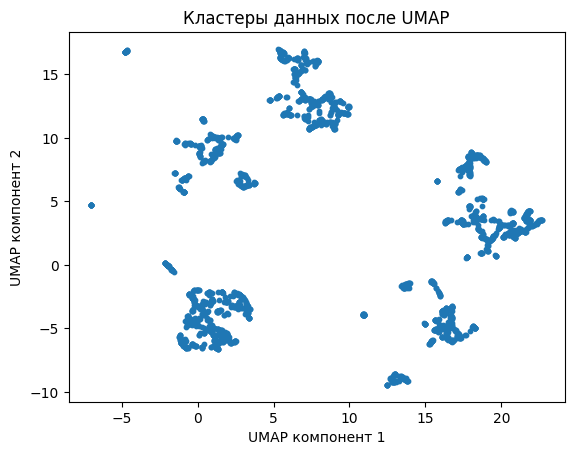

In [67]:
# Снижение размерности с помощью UMAP
umap = UMAP(n_components=2, random_state=42)
umap_data = umap.fit_transform(scaled_data)

# Визуализация кластеров
plt.scatter(umap_data[:, 0], umap_data[:, 1], cmap='viridis', s=10)
plt.title("Кластеры данных после UMAP")
plt.xlabel("UMAP компонент 1")
plt.ylabel("UMAP компонент 2")
plt.show()

На данном графике представлены кластеры данных после применения метода UMAP, который, в отличие от PCA, лучше сохраняет локальные структуры и может выявить более сложные скрытые кластеры. Вот что можно отметить:

1. **Наличие чётких подгрупп**
   - В отличие от PCA, здесь видны более отчётливые группы. Некоторые области содержат плотные скопления точек, что может свидетельствовать о потенциальных кластерах в данных.
   - Это говорит о том, что UMAP помог раскрыть структуру данных, и у нас появилась возможность выделить хотя бы несколько отдельных групп.
   - Визуально можно выделить 5–6 отдельных кластеров, что указывает на наличие разнообразия в наборе данных, которое удалось раскрыть благодаря UMAP.

2. **Разброс точек и аномалии**
   - На графике присутствуют также точки, которые находятся далеко от основных кластеров. Эти точки могут представлять аномальные или редкие случаи, которые не соответствуют общим паттернам в данных.
   - Подобные точки могут быть обработаны как выбросы или выделены как отдельные, небольшие кластеры	.

3. **Плотные кластеры в разных областях**
   - Визуально можно выделить несколько плотных групп, которые сформировались на различных уровнях компонент UMAP. Эти группы расположены на расстоянии друг от друга, что свидетельствует о наличии значимых различий в признаках объектов, входящих в эти кластеры.
   - Кластеры на графике разнесены неравномерно: некоторые группы расположены ближе друг к другу, а некоторые — значительно дальше. Это может означать, что между некоторыми кластерами есть схожесть по части признаков, в то время как другие группы имеют кардинальные отличия.
   - Например, кластеры, которые ближе друг к другу, могут представлять квартиры с похожими параметрами, но различиями по менее значимым характеристикам.




### Вывод
UMAP показал себя более эффективным для выделения скрытых структур и подгрупп в данных. Теперь видно, что данные имеют несколько кластеров с разной плотностью и разбросом, что можно использовать для построения более точной модели или для дальнейшего анализа.

## Основная логика программы

### BASELINE - решение
   - Для создания базового решения разобьём данные по одному признаку (например, цене) на несколько кластеров с равномерными интервалами, чтобы получить точки отсчета для сравнения качества моделей. Это будет простое, но эффективное условное разбиение данных, которое затем можно будет сравнить с результатами более сложной кластеризации, такой как KMeans.

#### Реализация

In [ ]:
# Функция для разбиения на кластеры по одному признаку
def bse_clustering(df, feature, n_clusters):
    min_value = df[feature].min()
    max_value = df[feature].max()
    
    # Рассчитываем шаг интервала для каждого кластера
    interval = (max_value - min_value) / n_clusters
    
    # Функция для назначения кластера в зависимости от значения признака
    def assign_cluster(value):
        return int((value - min_value) // interval)
    
    # Применение функции к указанному признаку и добавление результата в новый столбец
    cluster_column = f"BSE_Cluster"
    df[cluster_column] = df[feature].apply(assign_cluster)
    
    # Учитываем граничное значение (максимум) в последнем кластере
    df[cluster_column] = np.where(df[feature] == max_value, n_clusters - 1, df[cluster_column])
    
    return df["BSE_Cluster"]


df = pd.DataFrame(scaled_data, columns=numerical_columns)

# Разбиваем данные по цене на 5 кластеров
n_clusters = 5
bse_clusters = bse_clustering(df, 'Цена', n_clusters)

# Вывод первых строк для проверки
print(bse_clusters)


0       1
1       2
2       4
3       1
4       3
       ..
2240    1
2241    1
2242    0
2243    1
2244    1
Name: BSE_Cluster, Length: 2245, dtype: int64


In [69]:
clustered_bse_data = pd.DataFrame(scaled_data, columns=numerical_columns)
clustered_bse_data['Cluster'] = pd.DataFrame(bse_clusters)

##### Оценка

Для оценки я буду использовать **silhouette_score**

In [72]:
bse_silhouette_avg = silhouette_score(umap_data, clustered_bse_data['Cluster'])
print(f'Средний силуэтный коэффициент для {n_clusters} кластеров: {bse_silhouette_avg:.15f}')

Средний силуэтный коэффициент для 5 кластеров: -0.098851919174194


#### Визуализация

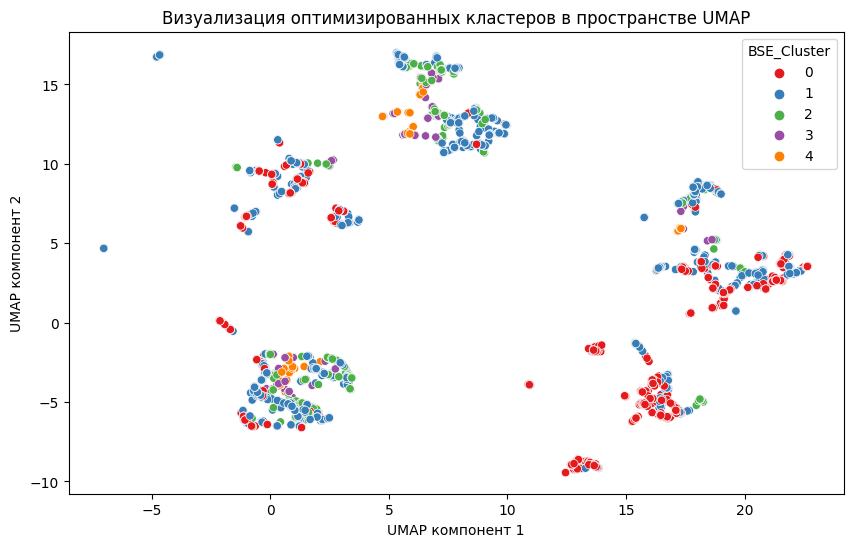

In [73]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=umap_data[:, 0], y=umap_data[:, 1], hue=bse_clusters, palette='Set1')
plt.title('Визуализация оптимизированных кластеров в пространстве UMAP')
plt.xlabel('UMAP компонент 1')
plt.ylabel('UMAP компонент 2')
plt.show()

### Использование KMeans
   - В этой реализации мы будем учитывать параметры, такие как:
		- `n_clusters` — количество кластеров для формирования.
		- `init` — метод инициализации начальных центроидов (`random` или `k-means++`).
		- `n_init` — количество различных инициализаций, из которых выбирается результат с наименьшей инерцией.

#### 1. Реализация

##### Подбор количества кластеров

Воспользуемся методом локтя для определения количества кластеров

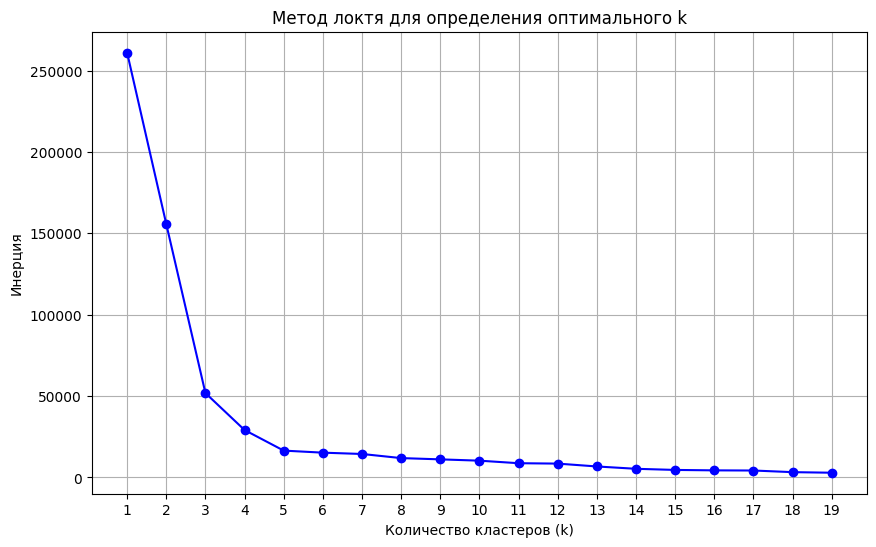

In [74]:
# Диапазон значений k для тестирования
k_values = range(1, 20)
inertia_values = []

# Рассчитаем инерцию для каждого значения k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans.fit(umap_data)
    inertia_values.append(kmeans.inertia_)

# Построение графика метода локтя
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia_values, 'bo-', color='blue')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Инерция')
plt.title('Метод локтя для определения оптимального k')
plt.xticks(k_values)
plt.grid(True)
plt.show()

Исходя из вышепоказанного графика видно, что нас интересуют значения 4 - 6, место, где сильнее весго меняется направление графика, что подтверджается визуально на графике распределения данных, так как там также наблюдается 5 подгрупп.

In [75]:
optimal_k = 5

##### Обучение модели

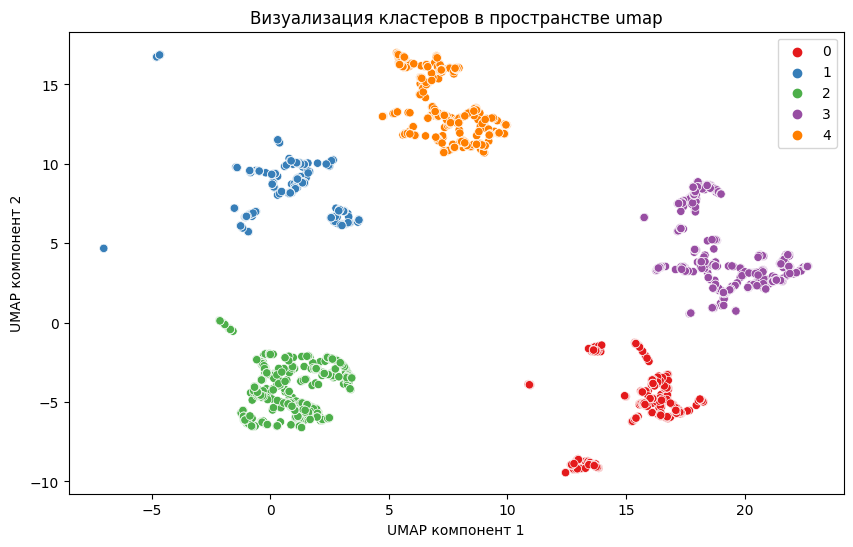

In [76]:
# Кластеризация с помощью KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(umap_data)


# Визуализация кластеров в пространстве umap
plt.figure(figsize=(10, 6))
sns.scatterplot(x=umap_data[:, 0], y=umap_data[:, 1], hue=clusters, palette='Set1')
plt.title('Визуализация кластеров в пространстве umap')
plt.xlabel('UMAP компонент 1')
plt.ylabel('UMAP компонент 2')
plt.show()

In [77]:
clustered_kmeans_data = pd.DataFrame(scaled_data, columns=numerical_columns)
clustered_kmeans_data['Cluster'] = pd.DataFrame(clusters)

##### Оценка

Для оценки я буду использовать **silhouette_score**

In [78]:
knear_score = silhouette_score(umap_data, clustered_kmeans_data['Cluster'])
print(f'Средний силуэтный коэффициент для {optimal_k} кластеров: {knear_score:.15f}')

Средний силуэтный коэффициент для 5 кластеров: 0.675920784473419


#### 2. Настройка и подбор гиперпараметров с помощью Optuna

In [79]:
import optuna
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Функция для оптимизации
def objective(trial):
    # Выбор значений гиперпараметров для текущего запуска
    n_clusters = trial.suggest_int('n_clusters', 2, 10)
    init = trial.suggest_categorical('init', ['k-means++', 'random'])
    n_init = trial.suggest_int('n_init', 10, 30)
    
    # Инициализация и обучение модели KMeans
    kmeans = KMeans(n_clusters=n_clusters, init=init, n_init=n_init, random_state=42)
    cluster_labels = kmeans.fit_predict(umap_data)
    
    # Расчёт метрики силуэта
    score = silhouette_score(umap_data, cluster_labels)
    return score

# Создание и запуск оптимизатора
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Наилучшие гиперпараметры
print("\nЛучшие гиперпараметры:", study.best_params)
print("Максимальное значение силуэта:", study.best_value)


[I 2024-11-13 19:16:03,861] A new study created in memory with name: no-name-93d88059-1253-426a-8e72-5e7a64a5cb43
[I 2024-11-13 19:16:04,181] Trial 0 finished with value: 0.535323441028595 and parameters: {'n_clusters': 8, 'init': 'random', 'n_init': 18}. Best is trial 0 with value: 0.535323441028595.
[I 2024-11-13 19:16:04,357] Trial 1 finished with value: 0.6315593123435974 and parameters: {'n_clusters': 9, 'init': 'random', 'n_init': 25}. Best is trial 1 with value: 0.6315593123435974.
[I 2024-11-13 19:16:04,554] Trial 2 finished with value: 0.5488804578781128 and parameters: {'n_clusters': 9, 'init': 'k-means++', 'n_init': 11}. Best is trial 1 with value: 0.6315593123435974.
[I 2024-11-13 19:16:04,726] Trial 3 finished with value: 0.542853832244873 and parameters: {'n_clusters': 10, 'init': 'k-means++', 'n_init': 11}. Best is trial 1 with value: 0.6315593123435974.
[I 2024-11-13 19:16:04,868] Trial 4 finished with value: 0.6518997550010681 and parameters: {'n_clusters': 6, 'init': 


Лучшие гиперпараметры: {'n_clusters': 5, 'init': 'k-means++', 'n_init': 27}
Максимальное значение силуэта: 0.6759207844734192


Количество кластеров равное 5 подтвердилось

#### 3. Обучение модели с оптимальными гиперпараметрами

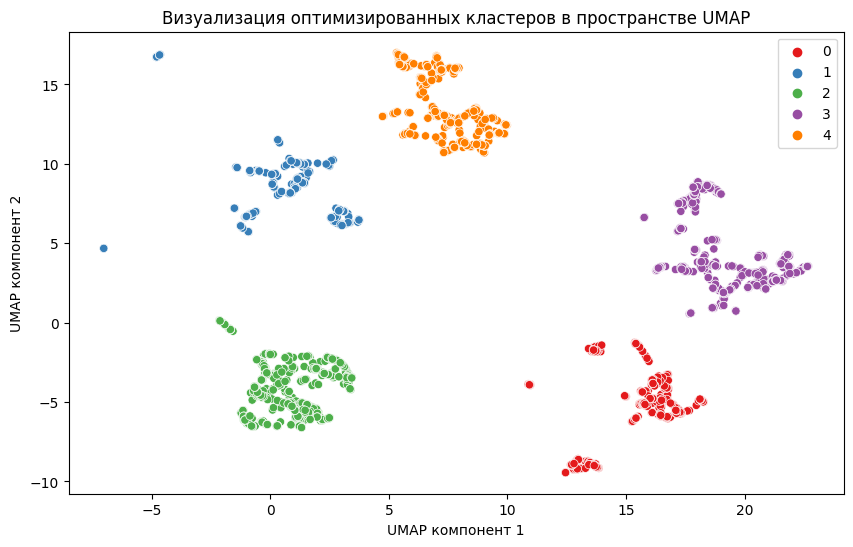

In [80]:
# Обучение модели KMeans с лучшими параметрами
best_kmeans = KMeans(
    n_clusters=study.best_params['n_clusters'],
    init=study.best_params['init'],
    n_init=study.best_params['n_init'],
    random_state=42
)
best_clusters = best_kmeans.fit_predict(umap_data)

# Визуализация полученных кластеров
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=umap_data[:, 0], y=umap_data[:, 1], hue=best_clusters, palette='Set1')
plt.title('Визуализация оптимизированных кластеров в пространстве UMAP')
plt.xlabel('UMAP компонент 1')
plt.ylabel('UMAP компонент 2')
plt.show()

In [81]:
best_clustered_kmeans_data = pd.DataFrame(scaled_data, columns=numerical_columns)
best_clustered_kmeans_data['Cluster'] = pd.DataFrame(best_clusters)

##### Оценка

Для оценки я буду использовать **silhouette_score**

In [82]:
best_knear_score = silhouette_score(umap_data, best_clustered_kmeans_data['Cluster'])
print(f'Средний силуэтный коэффициент для {optimal_k} кластеров: {best_knear_score:.15f}')

Средний силуэтный коэффициент для 5 кластеров: 0.675920784473419


#### 4. Анализ кластеров

In [83]:
clustered_kmeans_data

,Общая площадь,Грузовой лифт,Пассажирский лифт,Цена,Этаж,Год постройки,Этажей в доме,Площадь кухни,Количество комнат,Жилая площадь,Cluster
0,-1.403543,1.691544,0.681661,0.158823,1.626550,1.742992,3.119646,-0.512359,-1.796682,-0.901701,2
1,-0.693567,-0.548879,0.681661,0.761839,-0.517669,-0.900901,0.124388,-0.588724,-0.640274,-0.700786,1
2,0.619219,1.691544,0.681661,2.924133,-0.211352,0.421045,0.815601,-0.054170,0.516134,0.389898,2
3,-1.222700,1.691544,0.681661,-0.165878,0.401282,1.798073,-0.106017,-0.168717,-1.796682,-0.758190,2
4,1.188539,-0.548879,0.681661,2.474547,1.013916,-1.066145,0.124388,-0.512359,1.672542,1.289235,4
...,...,...,...,...,...,...,...,...,...,...,...
2240,0.619219,1.691544,0.681661,0.301548,-0.211352,-0.405171,-0.336421,0.327655,0.516134,0.581247,2
2241,0.619219,-0.548879,-1.110293,0.226617,-1.130303,1.687911,-1.258039,0.327655,0.516134,0.648218,3
2242,-0.854316,-0.548879,-1.110293,-0.911620,-0.823986,-0.680577,-0.797230,-0.817818,-0.640274,-0.949538,0
2243,0.284324,-0.548879,-1.110293,-0.412080,-0.517669,-0.405171,-0.797230,-0.817818,0.516134,0.351629,3


Чтобы определить, какие переменные влияют на кластеры, можно проанализировать, как каждый признак коррелирует с метками кластеров. Мы можем рассчитать средние значения признаков для каждого кластера и посмотреть, как они различаются.

Для начала сгруппируем данные по кластеру и найдем средние значения для каждого признака, чтобы выявить отличия.

In [84]:
cluster_means = clustered_kmeans_data.groupby('Cluster').mean()
cluster_means

,Общая площадь,Грузовой лифт,Пассажирский лифт,Цена,Этаж,Год постройки,Этажей в доме,Площадь кухни,Количество комнат,Жилая площадь
Cluster,,,,,,,,,,
0,-0.921260,-0.548879,-1.110293,-0.686619,-0.585739,-0.277930,-0.897846,-0.429976,-0.900242,-0.851615
1,-0.738667,-0.548879,0.636722,-0.294179,0.096886,-0.112154,0.286899,-0.113658,-0.796153,-0.845197
2,0.018084,1.647536,0.796858,0.377901,0.721821,0.922972,1.087561,0.530294,-0.396602,-0.130329
3,0.403034,-0.544635,-1.106899,-0.250200,-0.550157,-0.521071,-0.921596,-0.344660,0.800855,0.582859
4,0.818700,-0.548879,0.808806,0.620943,0.181902,-0.218189,0.296042,0.194397,0.890492,0.808043


Теперь можно увидеть средние значения каждого признака для разных кластеров. Это позволяет выявить следующие зависимости:

1. **Общая площадь**, **Жилая площадь** и **Количество комнат**:
   - Кластер 4 имеет наибольшие значения для общей и жилой площади, что указывает на наличие более крупных объектов в этой группе.
   - Кластер 0, наоборот, характеризуется наименьшими значениями по этим признакам, что говорит о меньших квартирах или комнатах.
   - Аналогично для **Количество комнат**

2. **Грузовой и Пассажирский лифт**:
   - Кластер 2 имеет положительные значения по этим признакам, что может указывать на современные или более дорогие здания с большим количеством лифтов.
   - Кластер 0 и 3 имеют отрицательные значения для пассажирского лифта, что может означать отсутствие или меньшее количество лифтов в этих группах.

3. **Цена**:
   - Самая высокая средняя цена у объектов из кластера 4, что может быть связано с большими площадями и наличием лифтов.
   - Самая низкая цена у объектов кластера 0, где также самые низкие значения площади и количество комнат.

4. **Этаж и Этажей в доме**:
   - Кластер 2 характеризуется наибольшим средним значением этажей и этажностью здания, что может свидетельствовать о более высоких зданиях.
   - Кластер 0 и 3 имеют низкие значения для этих признаков, что указывает на низкоэтажные здания.

5. **Год постройки**:
   - Кластер 2 показывает положительное значение, что может указывать на более новые постройки, в то время как кластеры 0 и 3 имеют отрицательные значения, что может говорить о старых зданиях.

Эти выводы позволяют предположить, что такие признаки, как **площадь, наличие лифтов, цена, этажность и год постройки**, существенно влияют на разделение объектов по кластерам.

### Создание KMeans вручную

- **Инициализация центроидов**: Сначала случайно выбираем начальные центроиды, используя выбранный метод инициализации (случайно или с `k-means++`), который помогает распределить начальные точки на больших расстояниях друг от друга, чтобы повысить качество итогового результата.
   
- **Назначение кластеров**: Для каждой точки данных рассчитывается расстояние до всех центроидов, и точка относится к ближайшему кластеру. Это делается на каждой итерации, пока не достигнется условие сходимости.

- **Обновление центроидов**: Центроиды пересчитываются как среднее значение всех точек, относящихся к каждому кластеру. Этот процесс повторяется до тех пор, пока центроиды не перестанут изменяться или пока не будет достигнуто максимальное количество итераций.

#### 1. Реализация алгоритма


##### Создание алгоритма кластеризации (аналог KMeans)


Для реализации KMeans мы создадим класс MyKMeans, который будет инициализировать центроиды случайным образом и повторять обновление центроидов и назначение кластеров до тех пор, пока они не перестанут изменяться или не достигнут максимального количества итераций.

In [ ]:
class MyKMeans:
    def __init__(self, n_clusters=5, max_iter=100, tol=1e-4, init='k-means++'):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.init = init
    
    def fit(self, X):
        # Инициализация центроидов
        if self.init == 'random':
            np.random.seed(42)
            random_idx = np.random.permutation(X.shape[0])[:self.n_clusters]
            self.centroids = X[random_idx]
        elif self.init == 'k-means++':
            self.centroids = self._init_centroids_kmeans_plus(X)
        
        for i in range(self.max_iter):
            # Обновление кластеров
            self.labels_ = self._assign_clusters(X)
            new_centroids = np.array([X[self.labels_ == j].mean(axis=0) for j in range(self.n_clusters)])
            
            # Проверка на сходимость
            if np.all(np.abs(new_centroids - self.centroids) < self.tol):
                break
            self.centroids = new_centroids
    
    def _init_centroids_kmeans_plus(self, X):
        centroids = [X[np.random.randint(0, X.shape[0])]]
        for _ in range(1, self.n_clusters):
            dist_sq = np.array([np.min([np.sum((x - centroid) ** 2) for centroid in centroids]) for x in X])
            probs = dist_sq / dist_sq.sum()
            cumulative_probs = np.cumsum(probs)
            r = np.random.rand()
            for j, p in enumerate(cumulative_probs):
                if r < p:
                    centroids.append(X[j])
                    break
        return np.array(centroids)
    
    def _assign_clusters(self, X):
        distances = np.array([[np.linalg.norm(x - centroid) for centroid in self.centroids] for x in X])
        return np.argmin(distances, axis=1)

    def predict(self, X):
        return self._assign_clusters(X)

##### Обучение модели

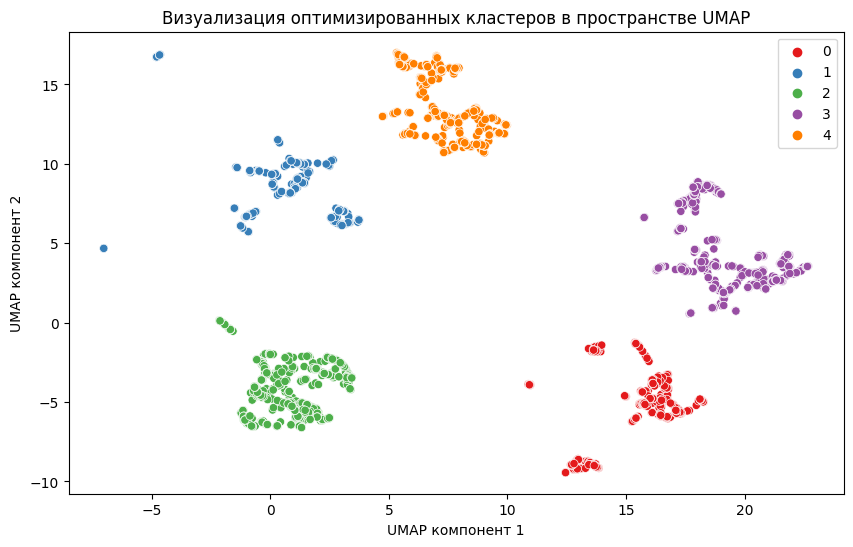

In [86]:
# Обучение модели с оптимальным количеством кластеров
custom_kmeans = MyKMeans(n_clusters=optimal_k)
custom_kmeans.fit(umap_data)
custom_cluster = custom_kmeans.labels_

# Визуализация
plt.figure(figsize=(10, 6))
sns.scatterplot(x=umap_data[:, 0], y=umap_data[:, 1], hue=best_clusters, palette='Set1')
plt.title('Визуализация оптимизированных кластеров в пространстве UMAP')
plt.xlabel('UMAP компонент 1')
plt.ylabel('UMAP компонент 2')
plt.show()

##### Оценка

In [87]:
# Оценка с помощью силуэтного коэффициента
custom_score = silhouette_score(umap_data, custom_cluster)
print(f'Средний силуэтный коэффициент для {optimal_k} кластеров: {custom_score:.15f}')


Средний силуэтный коэффициент для 5 кластеров: 0.675920784473419


#### 2. Настройка и подбор гиперпараметров с помощью Optuna

Для подбора гиперпараметров воспользуемся Optuna, чтобы найти оптимальное n_clusters и init, которые максимизируют силуэтный коэффициент.

In [88]:
# Функция для оптимизации
def objective(trial):
    n_clusters = trial.suggest_int('n_clusters', 2, 10)
    init = trial.suggest_categorical('init', ['random', 'k-means++'])
    
    model = MyKMeans(n_clusters=n_clusters, max_iter=300, tol=1e-4, init=init)
    model.fit(umap_data)
    cluster_labels = model.labels_
    
    score = silhouette_score(umap_data, cluster_labels)
    return score

# Создание и запуск оптимизатора
custom_study = optuna.create_study(direction='maximize')
custom_study.optimize(objective, n_trials=50)

# Наилучшие гиперпараметры
print("Лучшие гиперпараметры кастомного KMeans:", custom_study.best_params)
print("Максимальное значение силуэта кастомного KMeans:", custom_study.best_value)

[I 2024-11-13 19:16:15,924] A new study created in memory with name: no-name-7d3aa5d2-0ef2-4484-be72-757031d68802
[I 2024-11-13 19:16:16,398] Trial 0 finished with value: 0.6247667670249939 and parameters: {'n_clusters': 4, 'init': 'k-means++'}. Best is trial 0 with value: 0.6247667670249939.
[I 2024-11-13 19:16:18,078] Trial 1 finished with value: 0.5552759170532227 and parameters: {'n_clusters': 10, 'init': 'k-means++'}. Best is trial 0 with value: 0.6247667670249939.
[I 2024-11-13 19:16:18,258] Trial 2 finished with value: 0.6759207844734192 and parameters: {'n_clusters': 5, 'init': 'random'}. Best is trial 2 with value: 0.6759207844734192.
[I 2024-11-13 19:16:18,446] Trial 3 finished with value: 0.6356263160705566 and parameters: {'n_clusters': 3, 'init': 'random'}. Best is trial 2 with value: 0.6759207844734192.
[I 2024-11-13 19:16:18,617] Trial 4 finished with value: 0.6356263160705566 and parameters: {'n_clusters': 3, 'init': 'random'}. Best is trial 2 with value: 0.675920784473

Лучшие гиперпараметры кастомного KMeans: {'n_clusters': 5, 'init': 'random'}
Максимальное значение силуэта кастомного KMeans: 0.6759207844734192


#### 3. Обучение модели с оптимальными гиперпараметрами

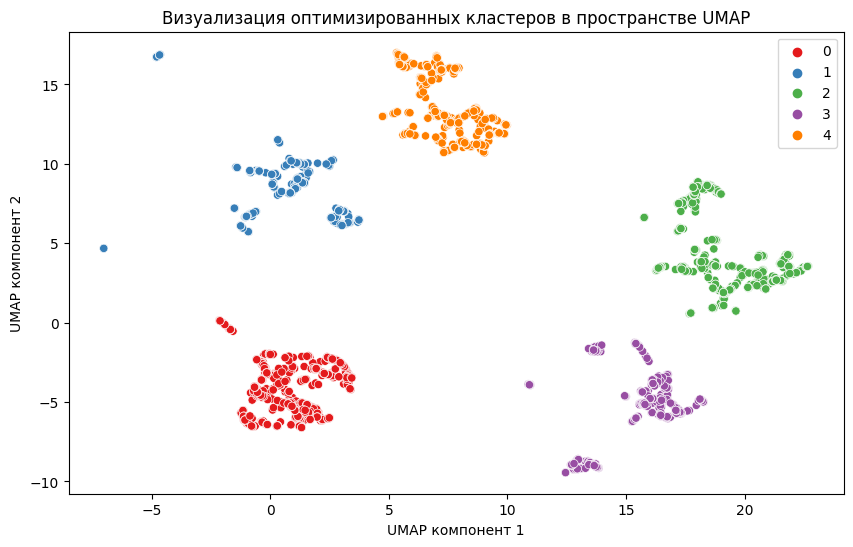

In [89]:
# Обучение модели с лучшими параметрами
best_model = MyKMeans(n_clusters=study.best_params['n_clusters'], init=study.best_params['init'], max_iter=300, tol=1e-4)
best_model.fit(umap_data)
best_clusters = best_model.labels_

# Визуализация
plt.figure(figsize=(10, 6))
sns.scatterplot(x=umap_data[:, 0], y=umap_data[:, 1], hue=best_clusters, palette='Set1')
plt.title('Визуализация оптимизированных кластеров в пространстве UMAP')
plt.xlabel('UMAP компонент 1')
plt.ylabel('UMAP компонент 2')
plt.show()

##### Оценка

In [90]:
# Оценка с помощью силуэтного коэффициента
best_custom_score = silhouette_score(umap_data, best_clusters)
print(f'Средний силуэтный коэффициент для {optimal_k} кластеров: {best_custom_score:.15f}')

Средний силуэтный коэффициент для 5 кластеров: 0.675920784473419


### Сравнение качества моделей
   - Сравнение **silhouette_score всех моделей**: базовой, sklearn и кастомной.

In [91]:
# Создание таблицы с оценкой точности после запуска
all_model_score_tunned = pd.DataFrame({	'Model_Name': ['BaseLine', 'KNear', 'Custom Knear'], 
										f'Silhouette score': [round(bse_silhouette_avg, 7), round(knear_score, 7), round(custom_score, 7)], 
										f'After optimum parameters': [round(bse_silhouette_avg, 7), round(best_knear_score, 7), round(best_custom_score, 7)]})
all_model_score_tunned = all_model_score_tunned.sort_values(by=[f'Silhouette score'])
all_model_score_tunned

,Model_Name,Silhouette score,After optimum parameters
0,BaseLine,-0.098852,-0.098852
1,KNear,0.675921,0.675921
2,Custom Knear,0.675921,0.675921
